In [133]:
import sqlite3

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# arguments
weather_station = 'KDAL'
load_zone = 'COAST'

In [10]:
# connect to database
conn = sqlite3.connect('../test_project.db')

In [11]:
# load 2014 load data
load_query = 'SELECT OperDay_HourEnding_UTC, ' + load_zone + " from loads WHERE STRFTIME('%Y', loads.OperDay_HourEnding_UTC) = '2014'"
load_df = pd.read_sql_query(load_query, conn)

In [12]:
# load 2014 weather data
weather_query = 'SELECT DateUTC, TemperatureF from ' + weather_station + " WHERE STRFTIME('%Y', " + weather_station + ".DateUTC) = '2014'"
weather_df = pd.read_sql_query(weather_query, conn)

In [13]:
# load 2015 load data
load2015_query = 'SELECT OperDay_HourEnding_UTC, ' + load_zone + " from loads WHERE STRFTIME('%Y', loads.OperDay_HourEnding_UTC) = '2015'"
load2015_df = pd.read_sql_query(load2015_query, conn)

In [14]:
# load 2015 weather data
weather2015_query = 'SELECT DateUTC, TemperatureF from ' + weather_station + " WHERE STRFTIME('%Y', " + weather_station + ".DateUTC) = '2015'"
weather2015_df = pd.read_sql_query(weather2015_query, conn)

In [15]:
# change datatypes

load_df = load_df.astype({'OperDay_HourEnding_UTC': 'datetime64[ns]'})
load_df = load_df.sort_values('OperDay_HourEnding_UTC')
load2015_df = load2015_df.astype({'OperDay_HourEnding_UTC': 'datetime64[ns]'})
load2015_df = load2015_df.sort_values('OperDay_HourEnding_UTC')


weather_df = weather_df.astype({'DateUTC': 'datetime64[ns]'})
weather_df = weather_df.sort_values('DateUTC')
weather2015_df = weather2015_df.astype({'DateUTC': 'datetime64[ns]'})
weather2015_df = weather2015_df.sort_values('DateUTC')

In [16]:
# join load and weather dataframes by date

merged_df = pd.merge_asof(load_df,weather_df, left_on='OperDay_HourEnding_UTC',right_on='DateUTC', tolerance=pd.Timedelta('15min'))
merged_df.dropna(inplace=True)

In [17]:
# drop outlier datapoints from train data

outlier_index = merged_df[merged_df['TemperatureF'] < -100].index
merged_df.drop(outlier_index, inplace=True)

In [18]:
# group df by date to find daily peak load

max_load_df = merged_df.loc[merged_df.groupby(merged_df['OperDay_HourEnding_UTC'].dt.date)[load_zone].idxmax()]

In [19]:
# merge 2015 dataframes by date

test_df = pd.merge_asof(load2015_df,weather2015_df, left_on='OperDay_HourEnding_UTC',right_on='DateUTC', tolerance=pd.Timedelta('15min'))
test_df.dropna(inplace=True)

# group df by date to find daily peak load

test_df = test_df.loc[test_df.groupby(test_df['OperDay_HourEnding_UTC'].dt.date)[load_zone].idxmax()]

In [20]:
# drop outlier datapoints from test data

outlier_index = test_df[test_df['TemperatureF'] < -100].index
test_df.drop(outlier_index, inplace=True)

In [157]:
test_df

,OperDay_HourEnding_UTC,COAST,DateUTC,TemperatureF
1,2015-01-01 01:00:00,11749.55,2015-01-01 00:53:00,35.1
25,2015-01-02 01:00:00,11085.66,2015-01-02 00:53:00,36.0
49,2015-01-03 01:00:00,10472.53,2015-01-03 00:53:00,41.0
75,2015-01-04 03:00:00,10284.50,2015-01-04 02:53:00,48.0
111,2015-01-05 15:00:00,12705.32,2015-01-05 14:53:00,30.0
...,...,...,...,...
8640,2015-12-27 01:00:00,11414.46,2015-12-27 00:53:00,66.9
8679,2015-12-28 16:00:00,10687.48,2015-12-28 15:53:00,35.1
8689,2015-12-29 02:00:00,11066.47,2015-12-29 01:53:00,36.0
8712,2015-12-30 01:00:00,10765.09,2015-12-30 00:53:00,42.1


In [51]:
from sklearn.preprocessing import MinMaxScaler

In [158]:
x_train = pd.concat([merged_df['TemperatureF'], merged_df['OperDay_HourEnding_UTC'].dt.hour, merged_df['OperDay_HourEnding_UTC'].dt.month], axis=1)
x_test = pd.concat([test_df['TemperatureF'], test_df['OperDay_HourEnding_UTC'].dt.hour, test_df['OperDay_HourEnding_UTC'].dt.month], axis=1)

In [159]:
#x_train = merged_df['TemperatureF'].values.reshape(-1,1)
x_train = x_train.values
y_train = merged_df[load_zone].values.reshape(-1,1)

#x_test = test_df['TemperatureF'].values.reshape(-1,1)
x_test = x_test.values
y_test = test_df[load_zone].values.reshape(-1,1)

In [160]:
scaler = MinMaxScaler()

In [162]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [163]:
x_test.max()

1.048331415420023

In [252]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow

In [485]:
model = Sequential()

model.add(Dense(3, activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))

model.add(Dense(1))

#opt = tensorflow.keras.optimizers.Adam(learning_rate=0.01)
#opt = tensorflow.keras.optimizers.SGD(learning_rate=0.1)

model.compile(optimizer='adam', loss='mse')
#model.compile(optimizer=opt, loss='mse')

In [ ]:
model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test), epochs=50000, batch_size=128)

Train on 8708 samples, validate on 365 samples
Epoch 1/50000
8708/8708 [==============================] - 0s 32us/sample - loss: 123756414.1259 - val_loss: 187771968.2630
Epoch 2/50000
8708/8708 [==============================] - 0s 12us/sample - loss: 123749775.8604 - val_loss: 187763653.2164
Epoch 3/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 123743002.1130 - val_loss: 187755271.9342
Epoch 4/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 123736272.4483 - val_loss: 187747031.0575
Epoch 5/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 123729682.1902 - val_loss: 187739017.1178
Epoch 6/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 123723344.9738 - val_loss: 187731359.7808
Epoch 7/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 123717289.5581 - val_loss: 187724048.8767
Epoch 8/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 12371148

Epoch 67/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 123359073.0436 - val_loss: 187281064.3288
Epoch 68/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 123352888.9591 - val_loss: 187273433.9068
Epoch 69/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 123346724.2995 - val_loss: 187265816.4164
Epoch 70/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 123340574.8204 - val_loss: 187258234.7836
Epoch 71/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 123334433.2641 - val_loss: 187250641.8411
Epoch 72/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 123328304.8672 - val_loss: 187243073.8411
Epoch 73/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 123322189.4644 - val_loss: 187235509.5233
Epoch 74/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 123316080.4483 - val_loss: 187227975.4082
Epoch 75

Epoch 133/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 122961725.3689 - val_loss: 186789915.4849
Epoch 134/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 122955743.7575 - val_loss: 186782514.7616
Epoch 135/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 122949774.8902 - val_loss: 186775117.8959
Epoch 136/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 122943793.8300 - val_loss: 186767724.7123
Epoch 137/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 122937828.9830 - val_loss: 186760354.1041
Epoch 138/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 122931864.8636 - val_loss: 186752968.1973
Epoch 139/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 122925882.3923 - val_loss: 186745590.1370
Epoch 140/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 122919896.4961 - val_loss: 186738176.5699


8708/8708 [==============================] - 0s 7us/sample - loss: 122186766.6403 - val_loss: 185831257.3808
Epoch 264/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 122180806.3721 - val_loss: 185823871.2986
Epoch 265/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 122174852.4538 - val_loss: 185816511.5616
Epoch 266/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 122168912.9187 - val_loss: 185809160.8986
Epoch 267/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 122162968.5622 - val_loss: 185801790.8603
Epoch 268/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 122157023.2724 - val_loss: 185794449.6219
Epoch 269/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 122151080.2793 - val_loss: 185787087.3425
Epoch 270/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 122145131.1015 - val_loss: 185779729.7096
Epoch 271/5000

8708/8708 [==============================] - 0s 7us/sample - loss: 121414530.7230 - val_loss: 184875360.7452
Epoch 394/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 121408598.6697 - val_loss: 184868011.9233
Epoch 395/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 121402674.8553 - val_loss: 184860675.2877
Epoch 396/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 121396754.9068 - val_loss: 184853367.6274
Epoch 397/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 121390842.3114 - val_loss: 184846020.4274
Epoch 398/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 121384900.8176 - val_loss: 184838650.4329
Epoch 399/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 121378966.3243 - val_loss: 184831322.7836
Epoch 400/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 121373044.2186 - val_loss: 184823985.2274
Epoch 401/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 120644807.1217 - val_loss: 183921947.2658
Epoch 524/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 120638883.8328 - val_loss: 183914629.6548
Epoch 525/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 120632978.9251 - val_loss: 183907295.1233
Epoch 526/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 120627070.7285 - val_loss: 183899985.6658
Epoch 527/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 120621162.6091 - val_loss: 183892668.4055
Epoch 528/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 120615260.2297 - val_loss: 183885360.2630
Epoch 529/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 120609351.4525 - val_loss: 183878043.3096
Epoch 530/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 120603455.0299 - val_loss: 183870700.1863
Epoch 531/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 119877719.4892 - val_loss: 182971204.5151
Epoch 654/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119871821.7290 - val_loss: 182963911.1452
Epoch 655/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119865916.4796 - val_loss: 182956555.7479
Epoch 656/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119860024.0808 - val_loss: 182949265.9288
Epoch 657/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119854140.3767 - val_loss: 182941974.3562
Epoch 658/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 119848243.6821 - val_loss: 182934665.7753
Epoch 659/50000
8708/8708 [==============================] - 0s 11us/sample - loss: 119842359.3937 - val_loss: 182927365.1726
Epoch 660/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 119836452.2995 - val_loss: 182920048.2630
Epoch 661/5000

8708/8708 [==============================] - 0s 7us/sample - loss: 119113137.9182 - val_loss: 182022957.7205
Epoch 784/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119107269.1484 - val_loss: 182015686.0055
Epoch 785/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119101395.6086 - val_loss: 182008413.7644
Epoch 786/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119095526.4529 - val_loss: 182001115.3534
Epoch 787/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119089650.7745 - val_loss: 181993809.8411
Epoch 788/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119083773.1925 - val_loss: 181986537.1616
Epoch 789/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119077903.7575 - val_loss: 181979249.0521
Epoch 790/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 119072035.0942 - val_loss: 181971959.0137
Epoch 791/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 118351105.6720 - val_loss: 181077265.8849
Epoch 914/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 118345255.4451 - val_loss: 181069985.3151
Epoch 915/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 118339382.8277 - val_loss: 181062699.3534
Epoch 916/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 118333523.6968 - val_loss: 181055444.3836
Epoch 917/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 118327669.8392 - val_loss: 181048160.5699
Epoch 918/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 118321831.0409 - val_loss: 181040911.6493
Epoch 919/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 118315965.0822 - val_loss: 181033623.7151
Epoch 920/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 118310119.9743 - val_loss: 181026376.0219
Epoch 921/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 117591682.4621 - val_loss: 180134167.2329
Epoch 1044/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 117585861.4240 - val_loss: 180126919.8904
Epoch 1045/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 117580015.6913 - val_loss: 180119659.5726
Epoch 1046/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 117574181.2770 - val_loss: 180112420.8658
Epoch 1047/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 117568336.2866 - val_loss: 180105160.2411
Epoch 1048/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 117562504.7000 - val_loss: 180097902.5973
Epoch 1049/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 117556692.3583 - val_loss: 180090707.0247
Epoch 1050/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 117550860.4796 - val_loss: 180083441.2712
Epoch 105

8708/8708 [==============================] - 0s 7us/sample - loss: 116834818.7855 - val_loss: 179193608.6795
Epoch 1174/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116829015.5186 - val_loss: 179186413.8959
Epoch 1175/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116823197.7804 - val_loss: 179179171.8137
Epoch 1176/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116817371.7520 - val_loss: 179171915.7479
Epoch 1177/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116811542.8130 - val_loss: 179164703.2548
Epoch 1178/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116805738.5760 - val_loss: 179157478.7507
Epoch 1179/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116799940.7625 - val_loss: 179150255.5178
Epoch 1180/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116794129.8080 - val_loss: 179143044.2521
Epoch 118

8708/8708 [==============================] - 0s 7us/sample - loss: 116080623.2797 - val_loss: 178255774.9041
Epoch 1304/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116074833.3376 - val_loss: 178248569.8630
Epoch 1305/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116069042.1608 - val_loss: 178241391.2548
Epoch 1306/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116063255.8898 - val_loss: 178234172.9315
Epoch 1307/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116057470.3941 - val_loss: 178226976.9205
Epoch 1308/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116051680.1617 - val_loss: 178219754.3890
Epoch 1309/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116045887.1364 - val_loss: 178212553.6877
Epoch 1310/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 116040098.2637 - val_loss: 178205363.7260
Epoch 131

8708/8708 [==============================] - 0s 8us/sample - loss: 115328889.2090 - val_loss: 177320361.7315
Epoch 1434/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 115323118.9600 - val_loss: 177313206.7507
Epoch 1435/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 115317346.3666 - val_loss: 177305997.9397
Epoch 1436/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 115311566.1773 - val_loss: 177298810.6521
Epoch 1437/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 115305788.2150 - val_loss: 177291617.6658
Epoch 1438/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 115300014.0524 - val_loss: 177284418.0164
Epoch 1439/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 115294249.1355 - val_loss: 177277229.1507
Epoch 1440/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 115288467.9467 - val_loss: 177270057.9068
Epoch 14

8708/8708 [==============================] - 0s 7us/sample - loss: 114579783.4451 - val_loss: 176387590.7945
Epoch 1564/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 114574026.3261 - val_loss: 176380424.6795
Epoch 1565/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 114568277.7951 - val_loss: 176373277.2384
Epoch 1566/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 114562534.5080 - val_loss: 176366112.7890
Epoch 1567/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 114556789.2733 - val_loss: 176358959.3863
Epoch 1568/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 114551033.9807 - val_loss: 176351787.4411
Epoch 1569/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 114545287.5407 - val_loss: 176344635.2219
Epoch 1570/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 114539537.1135 - val_loss: 176337484.1863
Epoch 157

8708/8708 [==============================] - 0s 7us/sample - loss: 113833202.4621 - val_loss: 175457374.3342
Epoch 1694/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113827478.4272 - val_loss: 175450217.2493
Epoch 1695/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113821745.6831 - val_loss: 175443074.6301
Epoch 1696/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113816021.1704 - val_loss: 175435931.7918
Epoch 1697/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113810302.0266 - val_loss: 175428808.1096
Epoch 1698/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113804573.2476 - val_loss: 175421658.0822
Epoch 1699/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113798848.2131 - val_loss: 175414525.5014
Epoch 1700/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113793122.4401 - val_loss: 175407362.0164
Epoch 170

8708/8708 [==============================] - 0s 7us/sample - loss: 113089229.2329 - val_loss: 174529713.9288
Epoch 1824/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113083520.4483 - val_loss: 174522593.4027
Epoch 1825/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 113077813.8907 - val_loss: 174515476.9973
Epoch 1826/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113072112.5145 - val_loss: 174508363.5726
Epoch 1827/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113066398.2067 - val_loss: 174501230.4658
Epoch 1828/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113060688.0882 - val_loss: 174494111.5616
Epoch 1829/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113054981.6959 - val_loss: 174486996.7342
Epoch 1830/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 113049275.4580 - val_loss: 174479867.3534
Epoch 183

8708/8708 [==============================] - 0s 7us/sample - loss: 112347963.5829 - val_loss: 173604815.0795
Epoch 1954/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 112342285.6959 - val_loss: 173597743.3425
Epoch 1955/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 112336603.4433 - val_loss: 173590646.4438
Epoch 1956/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 112330914.0064 - val_loss: 173583549.1068
Epoch 1957/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 112325235.7593 - val_loss: 173576457.6438
Epoch 1958/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 112319545.8337 - val_loss: 173569363.6384
Epoch 1959/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 112313842.8884 - val_loss: 173562218.3890
Epoch 1960/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 112308120.9371 - val_loss: 173555068.0986
Epoch 196

8708/8708 [==============================] - 0s 8us/sample - loss: 111609189.2329 - val_loss: 172682407.6712
Epoch 2084/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 111603505.8962 - val_loss: 172675297.0959
Epoch 2085/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 111597839.8420 - val_loss: 172668204.1863
Epoch 2086/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 111592174.7763 - val_loss: 172661144.7233
Epoch 2087/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 111586510.6256 - val_loss: 172654069.0411
Epoch 2088/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 111580833.6941 - val_loss: 172646972.6247
Epoch 2089/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 111575167.1475 - val_loss: 172639895.8466
Epoch 2090/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 111569491.1530 - val_loss: 172632805.3918
Epoch 209

8708/8708 [==============================] - 0s 7us/sample - loss: 110873070.2949 - val_loss: 171762652.9315
Epoch 2214/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110867418.4217 - val_loss: 171755578.1260
Epoch 2215/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110861737.5471 - val_loss: 171748474.2137
Epoch 2216/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110856102.9380 - val_loss: 171741440.6137
Epoch 2217/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110850449.5728 - val_loss: 171734359.4959
Epoch 2218/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110844800.4998 - val_loss: 171727309.6329
Epoch 2219/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110839154.4474 - val_loss: 171720255.7370
Epoch 2220/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110833498.4584 - val_loss: 171713173.7425
Epoch 222

8708/8708 [==============================] - 0s 7us/sample - loss: 110139394.7671 - val_loss: 170845308.4932
Epoch 2344/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110133758.1773 - val_loss: 170838249.6000
Epoch 2345/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110128128.6615 - val_loss: 170831213.5452
Epoch 2346/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 110122500.1672 - val_loss: 170824184.9863
Epoch 2347/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110116873.4662 - val_loss: 170817147.5726
Epoch 2348/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110111247.9192 - val_loss: 170810102.0932
Epoch 2349/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110105617.7124 - val_loss: 170803055.9123
Epoch 2350/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 110099975.7097 - val_loss: 170795994.8274
Epoch 235

8708/8708 [==============================] - 0s 7us/sample - loss: 109408368.0514 - val_loss: 169930638.1589
Epoch 2474/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 109402750.1479 - val_loss: 169923605.9616
Epoch 2475/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 109397150.9674 - val_loss: 169916605.0630
Epoch 2476/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 109391532.6045 - val_loss: 169909563.0466
Epoch 2477/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 109385924.1158 - val_loss: 169902551.8466
Epoch 2478/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 109380306.8406 - val_loss: 169895514.9151
Epoch 2479/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 109374687.5627 - val_loss: 169888481.0521
Epoch 2480/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 109369081.2053 - val_loss: 169881465.1616
Epoch 248

8708/8708 [==============================] - 0s 7us/sample - loss: 108679874.8443 - val_loss: 169018496.1315
Epoch 2604/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 108674289.7933 - val_loss: 169011508.0767
Epoch 2605/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 108668701.0638 - val_loss: 169004504.4603
Epoch 2606/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 108663115.3771 - val_loss: 168997497.1616
Epoch 2607/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 108657528.5034 - val_loss: 168990518.4000
Epoch 2608/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 108651953.2715 - val_loss: 168983538.8055
Epoch 2609/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 108646357.4901 - val_loss: 168976514.3233
Epoch 2610/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 108640755.5645 - val_loss: 168969493.6548
Epoch 261

8708/8708 [==============================] - 0s 7us/sample - loss: 107953942.5264 - val_loss: 168108922.6959
Epoch 2734/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107948382.4786 - val_loss: 168101956.1644
Epoch 2735/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107942821.5048 - val_loss: 168094984.3288
Epoch 2736/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107937243.0096 - val_loss: 168087979.4849
Epoch 2737/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107931646.5301 - val_loss: 168080951.2767
Epoch 2738/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107926058.4658 - val_loss: 168073957.0411
Epoch 2739/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107920479.2283 - val_loss: 168066968.7233
Epoch 2740/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107914909.6628 - val_loss: 168059985.2274
Epoch 274

8708/8708 [==============================] - 0s 7us/sample - loss: 107230617.3744 - val_loss: 167201921.7973
Epoch 2864/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107225066.1497 - val_loss: 167194992.6575
Epoch 2865/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107219510.7395 - val_loss: 167188003.7260
Epoch 2866/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107213963.5094 - val_loss: 167181060.3836
Epoch 2867/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107208417.0877 - val_loss: 167174092.5808
Epoch 2868/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107202875.6050 - val_loss: 167167143.1890
Epoch 2869/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107197333.2108 - val_loss: 167160189.1068
Epoch 2870/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 107191763.2044 - val_loss: 167153209.3808
Epoch 287

8708/8708 [==============================] - 0s 7us/sample - loss: 106869935.4929 - val_loss: 166749452.7123
Epoch 2929/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106864388.4244 - val_loss: 166742480.9644
Epoch 2930/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106858846.5521 - val_loss: 166735531.6164
Epoch 2931/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106853297.7970 - val_loss: 166728576.5260
Epoch 2932/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106847746.0799 - val_loss: 166721607.5397
Epoch 2933/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106842198.1442 - val_loss: 166714634.4767
Epoch 2934/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106836662.1442 - val_loss: 166707699.3753
Epoch 2935/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106831129.3486 - val_loss: 166700757.4795
Epoch 293

8708/8708 [==============================] - 0s 7us/sample - loss: 106150534.6293 - val_loss: 165846406.6630
Epoch 3059/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106144990.8535 - val_loss: 165839446.6630
Epoch 3060/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106139472.4593 - val_loss: 165832527.8685
Epoch 3061/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106133948.2517 - val_loss: 165825593.6438
Epoch 3062/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106128405.2476 - val_loss: 165818610.3671
Epoch 3063/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106122878.9564 - val_loss: 165811689.5562
Epoch 3064/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106117363.7997 - val_loss: 165804762.2137
Epoch 3065/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 106111854.0230 - val_loss: 165797842.3671
Epoch 306

8708/8708 [==============================] - 0s 7us/sample - loss: 105433704.9077 - val_loss: 164945957.4356
Epoch 3189/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 105428206.5374 - val_loss: 164939062.3123
Epoch 3190/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 105422702.8682 - val_loss: 164932135.5836
Epoch 3191/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 105417207.4525 - val_loss: 164925228.9753
Epoch 3192/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 105411702.5374 - val_loss: 164918306.8932
Epoch 3193/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 105406196.7184 - val_loss: 164911402.8274
Epoch 3194/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 105400681.9219 - val_loss: 164904457.0301
Epoch 3195/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 105395168.5880 - val_loss: 164897541.1288
Epoch 319

8708/8708 [==============================] - 0s 7us/sample - loss: 104719296.7166 - val_loss: 164047884.1863
Epoch 3319/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 104713813.2917 - val_loss: 164040991.1671
Epoch 3320/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 104708342.8461 - val_loss: 164034100.7781
Epoch 3321/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 104702867.8034 - val_loss: 164027238.5753
Epoch 3322/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 104697388.7368 - val_loss: 164020349.7205
Epoch 3323/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 104691910.8718 - val_loss: 164013441.6658
Epoch 3324/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 104686438.2655 - val_loss: 164006544.0877
Epoch 3325/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 104680956.2885 - val_loss: 163999670.4438
Epoch 332

8708/8708 [==============================] - 0s 7us/sample - loss: 104007546.8259 - val_loss: 163152511.9123
Epoch 3449/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 104002094.9233 - val_loss: 163145634.1918
Epoch 3450/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 103996626.0542 - val_loss: 163138760.7233
Epoch 3451/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 103991175.2540 - val_loss: 163131904.8767
Epoch 3452/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 103985708.0827 - val_loss: 163125016.4164
Epoch 3453/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 103980235.6123 - val_loss: 163118121.4685
Epoch 3454/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 103974771.4249 - val_loss: 163111241.6000
Epoch 3455/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 103969302.8498 - val_loss: 163104353.7973
Epoch 345

8708/8708 [==============================] - 0s 8us/sample - loss: 103298428.7809 - val_loss: 162259762.0603
Epoch 3579/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 103292954.3041 - val_loss: 162252848.8329
Epoch 3580/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 103287495.1291 - val_loss: 162245975.8904
Epoch 3581/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 103282046.8755 - val_loss: 162239120.0877
Epoch 3582/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 103276610.2931 - val_loss: 162232273.9726
Epoch 3583/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 103271171.2853 - val_loss: 162225430.6192
Epoch 3584/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 103265734.3280 - val_loss: 162218581.1288
Epoch 3585/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 103260287.7060 - val_loss: 162211715.9452
Epoch 358

8708/8708 [==============================] - 0s 7us/sample - loss: 102591893.6298 - val_loss: 161369588.3397
Epoch 3709/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 102586451.1897 - val_loss: 161362715.2219
Epoch 3710/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 102581004.2921 - val_loss: 161355865.5562
Epoch 3711/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 102575563.1125 - val_loss: 161349003.9671
Epoch 3712/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 102570119.4966 - val_loss: 161342137.9068
Epoch 3713/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 102564678.5632 - val_loss: 161335277.2384
Epoch 3714/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 102559226.3849 - val_loss: 161328404.3397
Epoch 3715/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 102553772.9904 - val_loss: 161321518.9041
Epoch 371

8708/8708 [==============================] - 0s 7us/sample - loss: 101883962.8112 - val_loss: 160476984.3726
Epoch 3839/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101878538.2269 - val_loss: 160470120.3288
Epoch 3840/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101873098.6863 - val_loss: 160463289.8630
Epoch 3841/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101867658.8774 - val_loss: 160456406.5315
Epoch 3842/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101862212.2774 - val_loss: 160449545.5562
Epoch 3843/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101856769.2127 - val_loss: 160442678.3562
Epoch 3844/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101851335.5811 - val_loss: 160435841.3151
Epoch 3845/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101845896.2168 - val_loss: 160428949.9616
Epoch 384

8708/8708 [==============================] - 0s 7us/sample - loss: 101178401.9182 - val_loss: 159586683.7479
Epoch 3969/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101172976.9334 - val_loss: 159579870.1589
Epoch 3970/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101167561.4846 - val_loss: 159573007.3863
Epoch 3971/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101162157.4203 - val_loss: 159566195.4192
Epoch 3972/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101156743.4672 - val_loss: 159559371.1781
Epoch 3973/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101151322.9508 - val_loss: 159552514.6740
Epoch 3974/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101145893.9164 - val_loss: 159545665.5342
Epoch 3975/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 101140465.9660 - val_loss: 159538829.9836
Epoch 397

8708/8708 [==============================] - 0s 7us/sample - loss: 100475433.1906 - val_loss: 158699013.4356
Epoch 4099/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 100470037.8870 - val_loss: 158692215.6274
Epoch 4100/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 100464670.1185 - val_loss: 158685425.9288
Epoch 4101/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 100459279.6619 - val_loss: 158678612.0329
Epoch 4102/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 100453902.0193 - val_loss: 158671805.2822
Epoch 4103/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 100448502.1516 - val_loss: 158664982.4438
Epoch 4104/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 100443092.3326 - val_loss: 158658147.0247
Epoch 4105/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 100437706.1461 - val_loss: 158651370.7836
Epoch 410

8708/8708 [==============================] - 0s 7us/sample - loss: 99775024.6100 - val_loss: 157813873.4027
Epoch 4229/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99769643.6527 - val_loss: 157807051.7918
Epoch 4230/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99764256.3895 - val_loss: 157800256.0438
Epoch 4231/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99758871.8052 - val_loss: 157793468.8438
Epoch 4232/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99753503.0262 - val_loss: 157786654.1589
Epoch 4233/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99748116.7956 - val_loss: 157779849.3370
Epoch 4234/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99742732.1929 - val_loss: 157773048.1973
Epoch 4235/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99737344.0808 - val_loss: 157766233.7315
Epoch 4236/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 99077290.1755 - val_loss: 156931423.4301
Epoch 4359/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 99071934.4051 - val_loss: 156924645.1288
Epoch 4360/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99066574.0450 - val_loss: 156917857.2274
Epoch 4361/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99061212.3656 - val_loss: 156911073.0959
Epoch 4362/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99055846.9417 - val_loss: 156904300.8438
Epoch 4363/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 99050493.5893 - val_loss: 156897523.8575
Epoch 4364/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99045118.8094 - val_loss: 156890719.6055
Epoch 4365/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 99039761.9697 - val_loss: 156883926.8822
Epoch 4366/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 98382162.3261 - val_loss: 156051589.4795
Epoch 4489/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 98376839.5994 - val_loss: 156044841.5562
Epoch 4490/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 98371494.2177 - val_loss: 156038081.2712
Epoch 4491/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 98366160.7056 - val_loss: 156031311.6055
Epoch 4492/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 98360818.3114 - val_loss: 156024552.8110
Epoch 4493/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 98355480.2683 - val_loss: 156017796.2959
Epoch 4494/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 98350126.4603 - val_loss: 156011023.3425
Epoch 4495/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 98344786.4290 - val_loss: 156004245.1726
Epoch 4496/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 97689679.3606 - val_loss: 155174399.2986
Epoch 4619/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 97684350.8167 - val_loss: 155167651.4192
Epoch 4620/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 97679025.4846 - val_loss: 155160906.4329
Epoch 4621/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 97673717.5563 - val_loss: 155154184.5918
Epoch 4622/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 97668399.8898 - val_loss: 155147431.0137
Epoch 4623/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 97663072.7938 - val_loss: 155140683.9671
Epoch 4624/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 97657763.2301 - val_loss: 155133976.0219
Epoch 4625/50000
8708/8708 [==============================] - 0s 11us/sample - loss: 97652457.1576 - val_loss: 155127248.5699
Epoch 4626/50000

8708/8708 [==============================] - 0s 7us/sample - loss: 96999977.6794 - val_loss: 154300049.2712
Epoch 4749/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 96994678.7836 - val_loss: 154293330.0164
Epoch 4750/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 96989372.5163 - val_loss: 154286597.6110
Epoch 4751/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 96984078.4345 - val_loss: 154279897.3370
Epoch 4752/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 96978782.1479 - val_loss: 154273167.7808
Epoch 4753/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 96973489.6390 - val_loss: 154266471.2767
Epoch 4754/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 96968197.7033 - val_loss: 154259751.9342
Epoch 4755/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 96962906.0248 - val_loss: 154253031.8466
Epoch 4756/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 96312849.3486 - val_loss: 153428269.6767
Epoch 4879/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 96307598.6550 - val_loss: 153421589.6986
Epoch 4880/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 96302319.8016 - val_loss: 153414907.0466
Epoch 4881/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 96297032.8636 - val_loss: 153408181.1288
Epoch 4882/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 96291748.9132 - val_loss: 153401475.5507
Epoch 4883/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 96286455.9743 - val_loss: 153394771.5068
Epoch 4884/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 96281204.1966 - val_loss: 153388087.1452
Epoch 4885/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 96275928.6137 - val_loss: 153381423.0795
Epoch 4886/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 95628361.7786 - val_loss: 152559135.6493
Epoch 5009/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 95623123.5939 - val_loss: 152552503.4521
Epoch 5010/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 95617886.3206 - val_loss: 152545822.2027
Epoch 5011/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 95612642.3813 - val_loss: 152539150.6411
Epoch 5012/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 95607375.2724 - val_loss: 152532468.6904
Epoch 5013/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 95602107.9577 - val_loss: 152525769.4685
Epoch 5014/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 95596843.1860 - val_loss: 152519103.8685
Epoch 5015/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 95591583.3753 - val_loss: 152512393.5562
Epoch 5016/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 94946294.8608 - val_loss: 151692376.6356
Epoch 5139/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94941064.2536 - val_loss: 151685704.7671
Epoch 5140/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94935832.5439 - val_loss: 151679061.0411
Epoch 5141/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94930606.4345 - val_loss: 151672438.9699
Epoch 5142/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94925380.5237 - val_loss: 151665795.7260
Epoch 5143/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94920154.8296 - val_loss: 151659125.8301
Epoch 5144/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94914915.2448 - val_loss: 151652469.6110
Epoch 5145/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94909698.6201 - val_loss: 151645861.8740
Epoch 5146/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 94266978.8847 - val_loss: 150828395.9671
Epoch 5269/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94261770.1424 - val_loss: 150821783.8904
Epoch 5270/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94256562.9215 - val_loss: 150815148.1425
Epoch 5271/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94251345.1447 - val_loss: 150808510.2027
Epoch 5272/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94246129.5361 - val_loss: 150801874.4548
Epoch 5273/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94240905.3229 - val_loss: 150795210.5205
Epoch 5274/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94235687.7850 - val_loss: 150788587.3096
Epoch 5275/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 94230482.4768 - val_loss: 150781961.9507
Epoch 5276/50000


8708/8708 [==============================] - 0s 9us/sample - loss: 93590224.7680 - val_loss: 149966964.2082
Epoch 5399/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 93585013.0124 - val_loss: 149960344.4164
Epoch 5400/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 93579810.2490 - val_loss: 149953736.7671
Epoch 5401/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 93574611.0574 - val_loss: 149947092.9973
Epoch 5402/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 93569412.1690 - val_loss: 149940481.0082
Epoch 5403/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 93564229.0492 - val_loss: 149933879.4959
Epoch 5404/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 93559021.6628 - val_loss: 149927238.8384
Epoch 5405/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 93553811.4286 - val_loss: 149920620.8000
Epoch 5406/50000

8708/8708 [==============================] - 0s 7us/sample - loss: 92916032.8562 - val_loss: 149108101.4795
Epoch 5529/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92910858.4290 - val_loss: 149101506.9808
Epoch 5530/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92905670.7653 - val_loss: 149094912.7452
Epoch 5531/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92900495.1034 - val_loss: 149088313.5123
Epoch 5532/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92895317.7033 - val_loss: 149081725.8082
Epoch 5533/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92890134.8002 - val_loss: 149075096.3288
Epoch 5534/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92884970.4621 - val_loss: 149068524.6247
Epoch 5535/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92879803.5351 - val_loss: 149061949.4137
Epoch 5536/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 92244613.6077 - val_loss: 148252056.3726
Epoch 5659/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 92239457.3817 - val_loss: 148245484.6685
Epoch 5660/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92234304.6909 - val_loss: 148238926.0274
Epoch 5661/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92229148.2885 - val_loss: 148232325.7863
Epoch 5662/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92223982.6256 - val_loss: 148225755.7479
Epoch 5663/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92218815.6288 - val_loss: 148219151.1233
Epoch 5664/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92213651.3771 - val_loss: 148212581.3479
Epoch 5665/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 92208498.1240 - val_loss: 148205999.8247
Epoch 5666/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 91575678.3904 - val_loss: 147398473.4247
Epoch 5789/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 91570541.0638 - val_loss: 147391910.1370
Epoch 5790/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 91565405.9458 - val_loss: 147385360.2192
Epoch 5791/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 91560260.5567 - val_loss: 147378792.9425
Epoch 5792/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 91555117.1337 - val_loss: 147372243.2877
Epoch 5793/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 91549983.5701 - val_loss: 147365655.4959
Epoch 5794/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 91544842.4254 - val_loss: 147359099.9671
Epoch 5795/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 91539721.9587 - val_loss: 147352573.5890
Epoch 5796/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 90909373.4754 - val_loss: 146547526.9699
Epoch 5919/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 90904266.8333 - val_loss: 146540995.6822
Epoch 5920/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90899152.6174 - val_loss: 146534451.5945
Epoch 5921/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90894034.4731 - val_loss: 146527917.9836
Epoch 5922/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90888922.2232 - val_loss: 146521378.4548
Epoch 5923/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90883795.8254 - val_loss: 146514840.7014
Epoch 5924/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90878680.1948 - val_loss: 146508306.4986
Epoch 5925/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90873565.0896 - val_loss: 146501771.0027
Epoch 5926/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 90245674.7193 - val_loss: 145699178.1260
Epoch 6049/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90240578.8112 - val_loss: 145692669.9836
Epoch 6050/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90235475.5792 - val_loss: 145686122.8712
Epoch 6051/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90230364.5200 - val_loss: 145679588.1644
Epoch 6052/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90225265.5361 - val_loss: 145673077.1726
Epoch 6053/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90220166.3390 - val_loss: 145666551.2329
Epoch 6054/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90215082.3482 - val_loss: 145660063.5178
Epoch 6055/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 90210009.1723 - val_loss: 145653573.1288
Epoch 6056/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 89584510.5999 - val_loss: 144853335.7151
Epoch 6179/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 89579421.0069 - val_loss: 144846821.7863
Epoch 6180/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 89574353.0069 - val_loss: 144840348.8877
Epoch 6181/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 89569269.7694 - val_loss: 144833830.9699
Epoch 6182/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 89564185.5728 - val_loss: 144827329.2712
Epoch 6183/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 89559098.3206 - val_loss: 144820830.0274
Epoch 6184/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 89554030.7285 - val_loss: 144814332.9753
Epoch 6185/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 89548942.1516 - val_loss: 144807819.0904
Epoch 6186/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 88926113.7712 - val_loss: 144010326.0055
Epoch 6309/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88921063.7648 - val_loss: 144003852.6685
Epoch 6310/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88916010.1222 - val_loss: 143997392.4384
Epoch 6311/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88910982.1828 - val_loss: 143990941.5452
Epoch 6312/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88905939.4910 - val_loss: 143984490.2575
Epoch 6313/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88900880.4520 - val_loss: 143977990.0932
Epoch 6314/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88895812.9536 - val_loss: 143971526.2685
Epoch 6315/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88890743.8861 - val_loss: 143965019.3534
Epoch 6316/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 88270195.4212 - val_loss: 143169756.4055
Epoch 6439/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88265153.4626 - val_loss: 143163290.3014
Epoch 6440/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88260104.5622 - val_loss: 143156842.7397
Epoch 6441/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88255066.3445 - val_loss: 143150362.8712
Epoch 6442/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88250038.0377 - val_loss: 143143914.3452
Epoch 6443/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88245000.2903 - val_loss: 143137461.8740
Epoch 6444/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88239959.3422 - val_loss: 143130973.1507
Epoch 6445/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 88234918.4970 - val_loss: 143124539.1781
Epoch 6446/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 87616915.8218 - val_loss: 142331832.5479
Epoch 6569/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 87611894.6569 - val_loss: 142325387.7041
Epoch 6570/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 87606885.9825 - val_loss: 142318970.1699
Epoch 6571/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 87601895.5994 - val_loss: 142312565.3041
Epoch 6572/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 87596877.3836 - val_loss: 142306124.0986
Epoch 6573/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 87591851.4506 - val_loss: 142299672.5479
Epoch 6574/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 87586831.3385 - val_loss: 142293241.6438
Epoch 6575/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 87581818.4474 - val_loss: 142286805.5233
Epoch 6576/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 86966556.7809 - val_loss: 141496929.4027
Epoch 6699/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 86961552.7570 - val_loss: 141490495.3425
Epoch 6700/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 86956548.2921 - val_loss: 141484067.8575
Epoch 6701/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 86951549.5232 - val_loss: 141477658.4329
Epoch 6702/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 86946547.1713 - val_loss: 141471224.3726
Epoch 6703/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 86941545.5214 - val_loss: 141464798.9479
Epoch 6704/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 86936539.2614 - val_loss: 141458362.3452
Epoch 6705/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 86931562.9141 - val_loss: 141452001.1397
Epoch 6706/50000


8708/8708 [==============================] - 0s 6us/sample - loss: 86318509.9054 - val_loss: 140664244.7342
Epoch 6829/50000
8708/8708 [==============================] - 0s 6us/sample - loss: 86313525.3284 - val_loss: 140657852.0110
Epoch 6830/50000
8708/8708 [==============================] - 0s 6us/sample - loss: 86308559.6178 - val_loss: 140651454.8164
Epoch 6831/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 86303594.1828 - val_loss: 140645085.5452
Epoch 6832/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 86298646.9839 - val_loss: 140638722.6301
Epoch 6833/50000
8708/8708 [==============================] - 0s 6us/sample - loss: 86293674.2196 - val_loss: 140632306.4986
Epoch 6834/50000
8708/8708 [==============================] - 0s 6us/sample - loss: 86288692.8691 - val_loss: 140625922.3233
Epoch 6835/50000
8708/8708 [==============================] - 0s 6us/sample - loss: 86283711.6509 - val_loss: 140619515.7041
Epoch 6836/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 85673332.5126 - val_loss: 139834521.8630
Epoch 6959/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85668371.0243 - val_loss: 139828144.3068
Epoch 6960/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85663420.0386 - val_loss: 139821765.4356
Epoch 6961/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85658461.6922 - val_loss: 139815375.4301
Epoch 6962/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85653492.4244 - val_loss: 139808993.4685
Epoch 6963/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85648540.3252 - val_loss: 139802630.6192
Epoch 6964/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85643609.8117 - val_loss: 139796309.7863
Epoch 6965/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85638684.2774 - val_loss: 139789932.7123
Epoch 6966/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 85030542.6991 - val_loss: 139007115.1342
Epoch 7089/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85025592.8672 - val_loss: 139000746.6082
Epoch 7090/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85020658.8553 - val_loss: 138994381.7425
Epoch 7091/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85015720.1837 - val_loss: 138988024.3288
Epoch 7092/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85010794.0616 - val_loss: 138981672.4603
Epoch 7093/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85005848.6284 - val_loss: 138975328.0438
Epoch 7094/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 85000910.3757 - val_loss: 138968957.5452
Epoch 7095/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 84995972.2848 - val_loss: 138962603.3973
Epoch 7096/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 84390485.9054 - val_loss: 138182493.4137
Epoch 7219/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 84385566.5227 - val_loss: 138176140.8219
Epoch 7220/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 84380642.7304 - val_loss: 138169805.5014
Epoch 7221/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 84375722.6238 - val_loss: 138163456.1534
Epoch 7222/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 84370807.2503 - val_loss: 138157126.6630
Epoch 7223/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 84365916.8948 - val_loss: 138150833.0959
Epoch 7224/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 84361007.1915 - val_loss: 138144496.7014
Epoch 7225/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 84356092.6964 - val_loss: 138138163.0685
Epoch 7226/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 83752849.5250 - val_loss: 137360217.9507
Epoch 7349/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83747957.3872 - val_loss: 137353925.5233
Epoch 7350/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83743062.8259 - val_loss: 137347596.0110
Epoch 7351/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83738173.9237 - val_loss: 137341324.7123
Epoch 7352/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83733302.0707 - val_loss: 137334999.2110
Epoch 7353/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83728432.5034 - val_loss: 137328728.5479
Epoch 7354/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83723565.6114 - val_loss: 137322458.6082
Epoch 7355/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83718669.1447 - val_loss: 137316139.7918
Epoch 7356/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 83126226.6495 - val_loss: 136551497.9726
Epoch 7479/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 83121459.0831 - val_loss: 136545350.4877
Epoch 7480/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 83116687.5921 - val_loss: 136539198.3781
Epoch 7481/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83111940.1819 - val_loss: 136533060.4712
Epoch 7482/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83107182.4860 - val_loss: 136526913.1836
Epoch 7483/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83102434.3041 - val_loss: 136520790.7507
Epoch 7484/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83097692.4869 - val_loss: 136514665.9288
Epoch 7485/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 83092946.6054 - val_loss: 136508551.1014
Epoch 7486/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 82508370.5466 - val_loss: 135753296.6575
Epoch 7609/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 82503594.5687 - val_loss: 135747122.7397
Epoch 7610/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 82498857.5305 - val_loss: 135741020.0548
Epoch 7611/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 82494119.0335 - val_loss: 135734887.4959
Epoch 7612/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 82489388.5200 - val_loss: 135728781.5890
Epoch 7613/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 82484659.9155 - val_loss: 135722659.2877
Epoch 7614/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 82479934.2912 - val_loss: 135716553.7315
Epoch 7615/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 82475210.7745 - val_loss: 135710441.7753
Epoch 7616/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 81893037.6739 - val_loss: 134957631.4740
Epoch 7739/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81888314.4143 - val_loss: 134951525.3479
Epoch 7740/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81883588.9058 - val_loss: 134945412.0329
Epoch 7741/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81878871.8126 - val_loss: 134939299.1562
Epoch 7742/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81874142.8792 - val_loss: 134933192.4603
Epoch 7743/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81869424.6615 - val_loss: 134927094.3781
Epoch 7744/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81864709.3652 - val_loss: 134921008.9644
Epoch 7745/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81859987.7446 - val_loss: 134914878.5973
Epoch 7746/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 81280284.6339 - val_loss: 134164581.4575
Epoch 7869/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81275571.3147 - val_loss: 134158473.4466
Epoch 7870/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81270862.2177 - val_loss: 134152379.6384
Epoch 7871/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81266171.6711 - val_loss: 134146311.5836
Epoch 7872/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81261437.3817 - val_loss: 134140166.7507
Epoch 7873/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81256745.9991 - val_loss: 134134108.0329
Epoch 7874/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81252063.3863 - val_loss: 134128040.5479
Epoch 7875/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 81247368.5328 - val_loss: 134121937.5123
Epoch 7876/50000


8708/8708 [==============================] - 0s 6us/sample - loss: 80669962.2012 - val_loss: 133373954.0822
Epoch 7999/50000
8708/8708 [==============================] - 0s 6us/sample - loss: 80665302.9674 - val_loss: 133367911.1014
Epoch 8000/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80660639.3973 - val_loss: 133361831.8027
Epoch 8001/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80655914.4731 - val_loss: 133355728.5699
Epoch 8002/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80651250.2453 - val_loss: 133349685.3918
Epoch 8003/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80646579.1530 - val_loss: 133343613.6767
Epoch 8004/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80641824.8893 - val_loss: 133337422.4219
Epoch 8005/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80637078.5687 - val_loss: 133331329.0301
Epoch 8006/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 80061970.1314 - val_loss: 132585578.3671
Epoch 8129/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80057316.5935 - val_loss: 132579546.5644
Epoch 8130/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80052669.7547 - val_loss: 132573527.3205
Epoch 8131/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80048026.3923 - val_loss: 132567504.9205
Epoch 8132/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80043373.1373 - val_loss: 132561448.5041
Epoch 8133/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80038721.9366 - val_loss: 132555427.4411
Epoch 8134/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80034075.8769 - val_loss: 132549378.3233
Epoch 8135/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 80029387.1750 - val_loss: 132543290.4767
Epoch 8136/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 79456604.5310 - val_loss: 131799887.0137
Epoch 8259/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 79451935.5811 - val_loss: 131793832.5479
Epoch 8260/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 79447304.0404 - val_loss: 131787817.4685
Epoch 8261/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 79442670.0597 - val_loss: 131781799.7370
Epoch 8262/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 79438017.3376 - val_loss: 131775774.5534
Epoch 8263/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 79433383.5296 - val_loss: 131769734.2466
Epoch 8264/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 79428749.1226 - val_loss: 131763723.7260
Epoch 8265/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 79424116.4612 - val_loss: 131757717.5671
Epoch 8266/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 78853419.7630 - val_loss: 131016287.8247
Epoch 8389/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78848756.2076 - val_loss: 131010235.5726
Epoch 8390/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78844143.5701 - val_loss: 131004233.1178
Epoch 8391/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78839520.7056 - val_loss: 130998235.1123
Epoch 8392/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78834910.9490 - val_loss: 130992225.0959
Epoch 8393/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78830273.0289 - val_loss: 130986204.0548
Epoch 8394/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78825643.4616 - val_loss: 130980173.8521
Epoch 8395/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78820992.8525 - val_loss: 130974128.6137
Epoch 8396/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 78253029.4277 - val_loss: 130235589.5233
Epoch 8519/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78248428.5604 - val_loss: 130229601.0082
Epoch 8520/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78243790.9086 - val_loss: 130223543.8685
Epoch 8521/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78239164.2811 - val_loss: 130217538.5205
Epoch 8522/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78234530.8994 - val_loss: 130211523.1781
Epoch 8523/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78229928.0551 - val_loss: 130205545.4685
Epoch 8524/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78225331.3532 - val_loss: 130199561.3808
Epoch 8525/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 78220741.4901 - val_loss: 130193593.9945
Epoch 8526/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 77655001.4846 - val_loss: 129457207.4082
Epoch 8649/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77650420.5788 - val_loss: 129451263.4740
Epoch 8650/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77645839.6913 - val_loss: 129445283.6603
Epoch 8651/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77641248.5696 - val_loss: 129439298.8274
Epoch 8652/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77636623.7740 - val_loss: 129433262.3123
Epoch 8653/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77632036.1378 - val_loss: 129427303.0137
Epoch 8654/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77627441.6647 - val_loss: 129421320.0219
Epoch 8655/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77622848.4851 - val_loss: 129415330.1699
Epoch 8656/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 77059027.2485 - val_loss: 128680753.4904
Epoch 8779/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 77054417.1024 - val_loss: 128674737.2712
Epoch 8780/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77049846.3353 - val_loss: 128668796.4493
Epoch 8781/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77045281.1612 - val_loss: 128662855.3644
Epoch 8782/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77040668.0570 - val_loss: 128656821.8301
Epoch 8783/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77036103.1475 - val_loss: 128650888.6356
Epoch 8784/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77031551.9045 - val_loss: 128644931.7699
Epoch 8785/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 77026984.5953 - val_loss: 128639009.1397
Epoch 8786/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 76465919.4341 - val_loss: 127907294.9260
Epoch 8909/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 76461355.9945 - val_loss: 127901314.0164
Epoch 8910/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 76456783.0372 - val_loss: 127895360.8110
Epoch 8911/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 76452203.0574 - val_loss: 127889388.6904
Epoch 8912/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 76447658.5062 - val_loss: 127883457.9288
Epoch 8913/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 76443112.4153 - val_loss: 127877521.0740
Epoch 8914/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 76438577.4626 - val_loss: 127871611.8575
Epoch 8915/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 76434004.4171 - val_loss: 127865631.4959
Epoch 8916/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 75875186.2196 - val_loss: 127136159.0137
Epoch 9039/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75870665.2458 - val_loss: 127130247.3863
Epoch 9040/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75866136.6762 - val_loss: 127124339.0466
Epoch 9041/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75861618.8149 - val_loss: 127118441.9945
Epoch 9042/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75857082.6752 - val_loss: 127112513.9507
Epoch 9043/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75852569.7161 - val_loss: 127106614.4438
Epoch 9044/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75848042.4364 - val_loss: 127100684.0767
Epoch 9045/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75843504.2646 - val_loss: 127094775.6274
Epoch 9046/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 75286796.7901 - val_loss: 126367320.8767
Epoch 9169/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75282290.8627 - val_loss: 126361450.7836
Epoch 9170/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 75277783.7207 - val_loss: 126355514.0164
Epoch 9171/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75273213.3615 - val_loss: 126349552.4384
Epoch 9172/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75268696.1433 - val_loss: 126343684.5370
Epoch 9173/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75264185.1925 - val_loss: 126337767.8466
Epoch 9174/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75259683.2926 - val_loss: 126331890.6959
Epoch 9175/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 75255160.0073 - val_loss: 126325981.9178
Epoch 9176/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 74700608.8342 - val_loss: 125600628.0329
Epoch 9299/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74696127.6252 - val_loss: 125594745.7315
Epoch 9300/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74691618.9508 - val_loss: 125588849.9726
Epoch 9301/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74687134.8829 - val_loss: 125582999.2329
Epoch 9302/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74682662.5044 - val_loss: 125577142.6192
Epoch 9303/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74678196.5714 - val_loss: 125571292.9973
Epoch 9304/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74673709.6739 - val_loss: 125565405.1068
Epoch 9305/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74669223.0740 - val_loss: 125559557.3260
Epoch 9306/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 74117301.9531 - val_loss: 124836916.1205
Epoch 9429/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74112835.7207 - val_loss: 124831036.3836
Epoch 9430/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74108361.9770 - val_loss: 124825203.7479
Epoch 9431/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74103904.1323 - val_loss: 124819373.7205
Epoch 9432/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74099403.0905 - val_loss: 124813476.5151
Epoch 9433/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74094944.5108 - val_loss: 124807625.8192
Epoch 9434/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74090467.4910 - val_loss: 124801737.2712
Epoch 9435/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 74085982.4970 - val_loss: 124795882.1918
Epoch 9436/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 73536350.6918 - val_loss: 124075518.5315
Epoch 9559/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 73531905.0345 - val_loss: 124069699.0027
Epoch 9560/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 73527466.0413 - val_loss: 124063849.7096
Epoch 9561/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 73523013.5563 - val_loss: 124058038.1151
Epoch 9562/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 73518570.3041 - val_loss: 124052195.9452
Epoch 9563/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 73514101.4571 - val_loss: 124046324.2959
Epoch 9564/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 73509616.5292 - val_loss: 124040436.5151
Epoch 9565/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 73505147.1383 - val_loss: 124034606.6192
Epoch 9566/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 72957641.4736 - val_loss: 123316274.5863
Epoch 9689/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 72953132.6192 - val_loss: 123310352.1753
Epoch 9690/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 72948687.1842 - val_loss: 123304544.1534
Epoch 9691/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 72944260.6743 - val_loss: 123298737.0521
Epoch 9692/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 72939841.0253 - val_loss: 123292938.9151
Epoch 9693/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 72935418.4915 - val_loss: 123287122.8493
Epoch 9694/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 72930962.4989 - val_loss: 123281262.0274
Epoch 9695/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 72926506.4456 - val_loss: 123275405.1726
Epoch 9696/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 72381782.7542 - val_loss: 122560023.6055
Epoch 9819/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 72377318.2545 - val_loss: 122554168.3507
Epoch 9820/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 72372901.6702 - val_loss: 122548354.2137
Epoch 9821/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 72368485.2329 - val_loss: 122542556.9315
Epoch 9822/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 72364071.9927 - val_loss: 122536771.5726
Epoch 9823/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 72359645.8484 - val_loss: 122530958.6849
Epoch 9824/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 72355248.7129 - val_loss: 122525176.6137
Epoch 9825/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 72350847.7960 - val_loss: 122519397.9836
Epoch 9826/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 71808023.2099 - val_loss: 121805770.7397
Epoch 9949/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71803639.3826 - val_loss: 121799994.4329
Epoch 9950/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71799244.7221 - val_loss: 121794212.3616
Epoch 9951/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71794836.0092 - val_loss: 121788411.5726
Epoch 9952/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71790447.1475 - val_loss: 121782631.1014
Epoch 9953/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71786023.0262 - val_loss: 121776817.5123
Epoch 9954/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71781614.2986 - val_loss: 121771013.8082
Epoch 9955/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71777189.8650 - val_loss: 121765204.3616
Epoch 9956/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 71236947.9430 - val_loss: 121054213.1288
Epoch 10079/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71232558.8241 - val_loss: 121048431.5836
Epoch 10080/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71228183.1034 - val_loss: 121042696.6795
Epoch 10081/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71223803.0188 - val_loss: 121036889.6658
Epoch 10082/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71219409.7602 - val_loss: 121031145.0959
Epoch 10083/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71215034.1093 - val_loss: 121025338.5205
Epoch 10084/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71210640.2572 - val_loss: 121019593.8849
Epoch 10085/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 71206288.3895 - val_loss: 121013859.7260
Epoch 1008

8708/8708 [==============================] - 0s 7us/sample - loss: 70668329.6500 - val_loss: 120305122.5644
Epoch 10209/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70663952.2315 - val_loss: 120299378.9370
Epoch 10210/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70659608.2021 - val_loss: 120293651.4192
Epoch 10211/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70655264.2315 - val_loss: 120287921.7315
Epoch 10212/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70650890.3261 - val_loss: 120282143.3644
Epoch 10213/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 70646501.6445 - val_loss: 120276326.1589
Epoch 10214/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 70642065.5067 - val_loss: 120270510.8603
Epoch 10215/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 70637674.4107 - val_loss: 120264718.4438
Epoch 1021

8708/8708 [==============================] - 0s 7us/sample - loss: 70101975.0005 - val_loss: 119558243.8356
Epoch 10339/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70097639.5333 - val_loss: 119552540.3616
Epoch 10340/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70093316.8764 - val_loss: 119546822.0055
Epoch 10341/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70088945.6573 - val_loss: 119541018.2356
Epoch 10342/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70084576.1874 - val_loss: 119535293.1068
Epoch 10343/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70080241.9752 - val_loss: 119529576.3068
Epoch 10344/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70075913.7088 - val_loss: 119523865.9726
Epoch 10345/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 70071579.6233 - val_loss: 119518137.8849
Epoch 1034

8708/8708 [==============================] - 0s 7us/sample - loss: 69538358.6918 - val_loss: 118814163.5726
Epoch 10469/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 69534027.0648 - val_loss: 118808469.3479
Epoch 10470/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 69529689.2035 - val_loss: 118802736.7452
Epoch 10471/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 69525382.2949 - val_loss: 118797047.6932
Epoch 10472/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 69521054.8792 - val_loss: 118791304.8986
Epoch 10473/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 69516734.8222 - val_loss: 118785627.5945
Epoch 10474/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 69512430.7322 - val_loss: 118779943.8466
Epoch 10475/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 69508132.1525 - val_loss: 118774248.3288
Epoch 1047

8708/8708 [==============================] - 0s 7us/sample - loss: 68977251.0537 - val_loss: 118072606.4219
Epoch 10599/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68972944.9444 - val_loss: 118066944.0658
Epoch 10600/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68968660.8838 - val_loss: 118061280.7890
Epoch 10601/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68964377.6757 - val_loss: 118055616.3288
Epoch 10602/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68960091.6160 - val_loss: 118049918.9699
Epoch 10603/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68955787.3330 - val_loss: 118044248.8986
Epoch 10604/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68951449.6573 - val_loss: 118038483.9014
Epoch 10605/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68947072.1323 - val_loss: 118032706.6301
Epoch 1060

8708/8708 [==============================] - 0s 7us/sample - loss: 68418304.4832 - val_loss: 117333138.1479
Epoch 10729/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68414029.4221 - val_loss: 117327480.1973
Epoch 10730/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68409761.6684 - val_loss: 117321830.0055
Epoch 10731/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68405478.9729 - val_loss: 117316167.1890
Epoch 10732/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68401211.7152 - val_loss: 117310515.3315
Epoch 10733/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68396921.4773 - val_loss: 117304840.9863
Epoch 10734/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68392646.8498 - val_loss: 117299152.0438
Epoch 10735/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 68388342.8976 - val_loss: 117293488.4384
Epoch 1073

8708/8708 [==============================] - 0s 7us/sample - loss: 67862156.1488 - val_loss: 116596550.4000
Epoch 10859/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67857882.8333 - val_loss: 116590886.4877
Epoch 10860/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67853625.0528 - val_loss: 116585238.1808
Epoch 10861/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67849346.5301 - val_loss: 116579533.9178
Epoch 10862/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67845065.2898 - val_loss: 116573903.0795
Epoch 10863/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67840813.5305 - val_loss: 116568265.1178
Epoch 10864/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67836560.5218 - val_loss: 116562618.7397
Epoch 10865/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67832299.8181 - val_loss: 116556969.4027
Epoch 1086

8708/8708 [==============================] - 0s 7us/sample - loss: 67308178.2159 - val_loss: 115862007.1671
Epoch 10989/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67303908.6119 - val_loss: 115856331.0027
Epoch 10990/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67299643.9063 - val_loss: 115850682.0822
Epoch 10991/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67295403.1897 - val_loss: 115845060.0986
Epoch 10992/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67291145.5030 - val_loss: 115839411.5726
Epoch 10993/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67286900.1746 - val_loss: 115833793.6000
Epoch 10994/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67282667.5498 - val_loss: 115828170.0384
Epoch 10995/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 67278439.4745 - val_loss: 115822563.2438
Epoch 1099

8708/8708 [==============================] - 0s 7us/sample - loss: 66756975.1768 - val_loss: 115130351.6712
Epoch 11119/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66752742.9196 - val_loss: 115124721.4247
Epoch 11120/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66748514.5485 - val_loss: 115119131.4411
Epoch 11121/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66744307.6950 - val_loss: 115113545.5342
Epoch 11122/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 66740085.6849 - val_loss: 115107923.0466
Epoch 11123/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66735840.8930 - val_loss: 115102288.7890
Epoch 11124/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 66731608.7533 - val_loss: 115096669.3699
Epoch 11125/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 66727379.4304 - val_loss: 115091054.4219
Epoch 1112

8708/8708 [==============================] - 0s 7us/sample - loss: 66208026.1350 - val_loss: 114400881.4247
Epoch 11249/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66203818.4437 - val_loss: 114395256.8767
Epoch 11250/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66199559.9045 - val_loss: 114389605.2603
Epoch 11251/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66195344.7791 - val_loss: 114384009.5342
Epoch 11252/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66191138.7781 - val_loss: 114378421.2822
Epoch 11253/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66186914.0763 - val_loss: 114372797.7644
Epoch 11254/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66182689.8613 - val_loss: 114367187.9233
Epoch 11255/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 66178485.2164 - val_loss: 114361580.0110
Epoch 1125

8708/8708 [==============================] - 0s 7us/sample - loss: 65661515.0060 - val_loss: 113673818.2575
Epoch 11379/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65657328.0937 - val_loss: 113668268.9096
Epoch 11380/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65653150.9968 - val_loss: 113662679.6932
Epoch 11381/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65648948.7588 - val_loss: 113657090.8055
Epoch 11382/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65644771.8640 - val_loss: 113651541.7425
Epoch 11383/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65640582.8792 - val_loss: 113645958.9918
Epoch 11384/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65636401.9954 - val_loss: 113640402.0603
Epoch 11385/50000
8708/8708 [==============================] - 0s 6us/sample - loss: 65632184.3087 - val_loss: 113634763.3096
Epoch 1138

8708/8708 [==============================] - 0s 7us/sample - loss: 65117528.0037 - val_loss: 112949295.8027
Epoch 11509/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65113355.2853 - val_loss: 112943739.1342
Epoch 11510/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65109166.7487 - val_loss: 112938158.3123
Epoch 11511/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65104993.9587 - val_loss: 112932593.4904
Epoch 11512/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65100793.8411 - val_loss: 112926996.7123
Epoch 11513/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65096625.5324 - val_loss: 112921448.8986
Epoch 11514/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65092409.5434 - val_loss: 112915830.9918
Epoch 11515/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 65088240.4887 - val_loss: 112910275.1123
Epoch 1151

8708/8708 [==============================] - 0s 7us/sample - loss: 64575622.5338 - val_loss: 112226747.2877
Epoch 11639/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64571478.5338 - val_loss: 112221194.6521
Epoch 11640/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64567286.1847 - val_loss: 112215609.9068
Epoch 11641/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64563150.6256 - val_loss: 112210098.9151
Epoch 11642/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64559016.8415 - val_loss: 112204590.7288
Epoch 11643/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64554865.0859 - val_loss: 112199032.5041
Epoch 11644/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64550716.8029 - val_loss: 112193493.5452
Epoch 11645/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64546566.4676 - val_loss: 112187943.7370
Epoch 1164

8708/8708 [==============================] - 0s 7us/sample - loss: 64036492.8507 - val_loss: 111507038.0055
Epoch 11769/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64032376.3418 - val_loss: 111501546.6082
Epoch 11770/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64028260.1782 - val_loss: 111496036.9534
Epoch 11771/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64024089.8374 - val_loss: 111490448.5041
Epoch 11772/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64019961.1612 - val_loss: 111484961.2274
Epoch 11773/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64015838.7120 - val_loss: 111479459.1123
Epoch 11774/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64011701.5416 - val_loss: 111473865.6658
Epoch 11775/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 64007478.8112 - val_loss: 111468240.4164
Epoch 1177

8708/8708 [==============================] - 0s 7us/sample - loss: 63500003.8328 - val_loss: 110790037.9397
Epoch 11899/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 63495880.1231 - val_loss: 110784506.6301
Epoch 11900/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 63491771.8512 - val_loss: 110779024.6795
Epoch 11901/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 63487662.2692 - val_loss: 110773538.0603
Epoch 11902/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 63483559.2650 - val_loss: 110768035.1562
Epoch 11903/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 63479426.1681 - val_loss: 110762515.4192
Epoch 11904/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 63475286.0524 - val_loss: 110756953.0301
Epoch 11905/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 63471120.3013 - val_loss: 110751394.2795
Epoch 1190

8708/8708 [==============================] - 0s 7us/sample - loss: 62965892.5962 - val_loss: 110075366.9699
Epoch 12029/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62961815.0299 - val_loss: 110069903.6274
Epoch 12030/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62957726.3739 - val_loss: 110064450.2356
Epoch 12031/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62953657.6996 - val_loss: 110058996.0986
Epoch 12032/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62949577.4626 - val_loss: 110053539.2219
Epoch 12033/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62945503.8457 - val_loss: 110048075.7699
Epoch 12034/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62941395.7979 - val_loss: 110042553.1616
Epoch 12035/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62937280.4336 - val_loss: 110037060.0767
Epoch 1203

8708/8708 [==============================] - 0s 7us/sample - loss: 62433872.3849 - val_loss: 109362661.0192
Epoch 12159/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62429790.9343 - val_loss: 109357182.7288
Epoch 12160/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62425708.0808 - val_loss: 109351720.5260
Epoch 12161/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62421633.8374 - val_loss: 109346249.9726
Epoch 12162/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62417549.0565 - val_loss: 109340746.0603
Epoch 12163/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62413451.7887 - val_loss: 109335301.6986
Epoch 12164/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62409368.0367 - val_loss: 109329820.1863
Epoch 12165/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 62405301.4681 - val_loss: 109324365.8959
Epoch 1216

8708/8708 [==============================] - 0s 7us/sample - loss: 61904309.7768 - val_loss: 108652411.5726
Epoch 12289/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61900255.0887 - val_loss: 108646927.6712
Epoch 12290/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61896181.2347 - val_loss: 108641498.2356
Epoch 12291/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61892128.3932 - val_loss: 108636030.2904
Epoch 12292/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 61888014.2655 - val_loss: 108630528.8986
Epoch 12293/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61883965.9421 - val_loss: 108625101.1288
Epoch 12294/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61879908.3620 - val_loss: 108619656.3288
Epoch 12295/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61875865.7639 - val_loss: 108614240.4822
Epoch 1229

8708/8708 [==============================] - 0s 7us/sample - loss: 61377706.7230 - val_loss: 107945278.7507
Epoch 12419/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61373656.3454 - val_loss: 107939812.7562
Epoch 12420/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61369543.2724 - val_loss: 107934282.4986
Epoch 12421/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61365456.5034 - val_loss: 107928790.9479
Epoch 12422/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61361423.2871 - val_loss: 107923392.0658
Epoch 12423/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61357410.3114 - val_loss: 107918000.1753
Epoch 12424/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61353381.1906 - val_loss: 107912588.0110
Epoch 12425/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 61349361.6169 - val_loss: 107907185.4027
Epoch 1242

8708/8708 [==============================] - 0s 7us/sample - loss: 60852989.9440 - val_loss: 107239822.2027
Epoch 12549/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60848986.5356 - val_loss: 107234406.6849
Epoch 12550/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60844960.8636 - val_loss: 107229007.1890
Epoch 12551/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60840959.7997 - val_loss: 107223618.8055
Epoch 12552/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60836951.1015 - val_loss: 107218228.4274
Epoch 12553/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60832944.1801 - val_loss: 107212846.6849
Epoch 12554/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60828907.6619 - val_loss: 107207403.2877
Epoch 12555/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60824893.9715 - val_loss: 107202010.5863
Epoch 1255

8708/8708 [==============================] - 0s 7us/sample - loss: 60331135.7575 - val_loss: 106537332.4932
Epoch 12679/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60327113.8043 - val_loss: 106531920.5699
Epoch 12680/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60323061.2807 - val_loss: 106526451.6603
Epoch 12681/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60319022.2545 - val_loss: 106521018.9589
Epoch 12682/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60315026.4529 - val_loss: 106515653.1945
Epoch 12683/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60311035.1603 - val_loss: 106510249.7315
Epoch 12684/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60307030.7340 - val_loss: 106504877.0192
Epoch 12685/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 60303049.4993 - val_loss: 106499497.9726
Epoch 1268

8708/8708 [==============================] - 0s 7us/sample - loss: 59811408.6468 - val_loss: 105836885.6986
Epoch 12809/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59807397.8585 - val_loss: 105831465.4247
Epoch 12810/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59803420.7212 - val_loss: 105826108.1205
Epoch 12811/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59799453.2513 - val_loss: 105820751.8247
Epoch 12812/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59795464.5733 - val_loss: 105815375.7808
Epoch 12813/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59791476.7515 - val_loss: 105809987.4630
Epoch 12814/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59787452.9242 - val_loss: 105804569.6219
Epoch 12815/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59783459.9945 - val_loss: 105799191.7151
Epoch 1281

8708/8708 [==============================] - 0s 7us/sample - loss: 59294429.1373 - val_loss: 105139213.0411
Epoch 12939/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59290451.4708 - val_loss: 105133883.7041
Epoch 12940/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59286502.7102 - val_loss: 105128544.1534
Epoch 12941/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59282531.2439 - val_loss: 105123162.7178
Epoch 12942/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59278562.0028 - val_loss: 105117817.2055
Epoch 12943/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59274569.7216 - val_loss: 105112424.5260
Epoch 12944/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59270609.6904 - val_loss: 105107081.6877
Epoch 12945/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 59266643.6555 - val_loss: 105101724.1205
Epoch 1294

8708/8708 [==============================] - 0s 7us/sample - loss: 58779719.3349 - val_loss: 104443822.1370
Epoch 13069/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58775767.1750 - val_loss: 104438483.9014
Epoch 13070/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58771829.1410 - val_loss: 104433147.7918
Epoch 13071/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58767845.1447 - val_loss: 104427740.7562
Epoch 13072/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58763899.0611 - val_loss: 104422421.7863
Epoch 13073/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58759940.6706 - val_loss: 104417077.9178
Epoch 13074/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58756017.4773 - val_loss: 104411776.4384
Epoch 13075/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58752090.7377 - val_loss: 104406476.8438
Epoch 1307

8708/8708 [==============================] - 0s 7us/sample - loss: 58267558.7818 - val_loss: 103750933.1068
Epoch 13199/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58263625.8778 - val_loss: 103745614.4658
Epoch 13200/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58259694.9931 - val_loss: 103740288.7014
Epoch 13201/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58255723.9192 - val_loss: 103734922.6082
Epoch 13202/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58251797.8870 - val_loss: 103729605.4575
Epoch 13203/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 58247838.7285 - val_loss: 103724251.3753
Epoch 13204/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 58243893.0620 - val_loss: 103718903.7370
Epoch 13205/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 58239961.4883 - val_loss: 103713571.1781
Epoch 1320

8708/8708 [==============================] - 0s 7us/sample - loss: 57757680.1323 - val_loss: 103060307.7699
Epoch 13329/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 57753791.7097 - val_loss: 103055032.7452
Epoch 13330/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 57749888.2462 - val_loss: 103049736.8767
Epoch 13331/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 57745986.9766 - val_loss: 103044436.0548
Epoch 13332/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 57742047.1199 - val_loss: 103039097.6877
Epoch 13333/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 57738144.2462 - val_loss: 103033816.5918
Epoch 13334/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 57734258.6550 - val_loss: 103028558.5753
Epoch 13335/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 57730360.8048 - val_loss: 103023264.9644
Epoch 1333

8708/8708 [==============================] - 0s 7us/sample - loss: 57250650.5319 - val_loss: 102372615.0356
Epoch 13459/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 57246774.8057 - val_loss: 102367364.7123
Epoch 13460/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 57242845.1484 - val_loss: 102362007.1671
Epoch 13461/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 57238918.4474 - val_loss: 102356705.0301
Epoch 13462/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 57235017.7400 - val_loss: 102351400.2849
Epoch 13463/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 57231142.0083 - val_loss: 102346138.2795
Epoch 13464/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 57227260.2407 - val_loss: 102340855.2110
Epoch 13465/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 57223343.2577 - val_loss: 102335554.7836
Epoch 134

8708/8708 [==============================] - 0s 7us/sample - loss: 56746039.5149 - val_loss: 101687324.6904
Epoch 13589/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56742170.5264 - val_loss: 101682070.3123
Epoch 13590/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56738301.3633 - val_loss: 101676814.5096
Epoch 13591/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56734447.7079 - val_loss: 101671574.1370
Epoch 13592/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56730574.3133 - val_loss: 101666283.5288
Epoch 13593/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56726692.4097 - val_loss: 101661053.3699
Epoch 13594/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56722837.3064 - val_loss: 101655808.1753
Epoch 13595/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 56718954.4511 - val_loss: 101650519.7151
Epoch 1359

8708/8708 [==============================] - 0s 7us/sample - loss: 56243921.3009 - val_loss: 101004531.6164
Epoch 13719/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 56240070.7065 - val_loss: 100999313.9288
Epoch 13720/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 56236231.2099 - val_loss: 100994071.4082
Epoch 13721/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56232383.7299 - val_loss: 100988848.3288
Epoch 13722/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56228498.7892 - val_loss: 100983531.2658
Epoch 13723/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56224607.7115 - val_loss: 100978266.4548
Epoch 13724/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56220761.2329 - val_loss: 100973003.4192
Epoch 13725/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 56216900.2774 - val_loss: 100967767.0137
Epoch 1372

8708/8708 [==============================] - 0s 7us/sample - loss: 55743795.3753 - val_loss: 100323575.1233
Epoch 13849/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 55739982.6036 - val_loss: 100318388.4712
Epoch 13850/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 55736165.5067 - val_loss: 100313160.8548
Epoch 13851/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 55732335.6665 - val_loss: 100307942.5753
Epoch 13852/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 55728510.7120 - val_loss: 100302735.4301
Epoch 13853/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 55724663.6105 - val_loss: 100297464.2411
Epoch 13854/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 55720758.6367 - val_loss: 100292155.5288
Epoch 13855/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 55716884.8525 - val_loss: 100286890.2795
Epoch 1385

8708/8708 [==============================] - 0s 7us/sample - loss: 55246910.4823 - val_loss: 99646107.0904
Epoch 13979/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 55243061.9237 - val_loss: 99640822.8822
Epoch 13980/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 55239224.3565 - val_loss: 99635614.4877
Epoch 13981/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 55235414.8498 - val_loss: 99630399.9781
Epoch 13982/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 55231604.5108 - val_loss: 99625222.9918
Epoch 13983/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 55227805.6151 - val_loss: 99620039.9562
Epoch 13984/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 55223994.6752 - val_loss: 99614826.5205
Epoch 13985/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 55220171.6932 - val_loss: 99609627.7918
Epoch 13986/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 54752217.8300 - val_loss: 98970707.1781
Epoch 14109/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54748421.4166 - val_loss: 98965528.6795
Epoch 14110/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54744633.8539 - val_loss: 98960343.0356
Epoch 14111/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54740828.8434 - val_loss: 98955167.5616
Epoch 14112/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54737050.2379 - val_loss: 98950000.8329
Epoch 14113/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54733257.6096 - val_loss: 98944811.8795
Epoch 14114/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54729450.8186 - val_loss: 98939582.3781
Epoch 14115/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54725620.6468 - val_loss: 98934381.0849
Epoch 14116/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 54259510.5668 - val_loss: 98297158.4219
Epoch 14239/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54255737.9752 - val_loss: 98291975.6932
Epoch 14240/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54251972.7919 - val_loss: 98286848.0000
Epoch 14241/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54248205.7051 - val_loss: 98281672.8329
Epoch 14242/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54244434.4915 - val_loss: 98276489.1836
Epoch 14243/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54240596.9527 - val_loss: 98271231.4301
Epoch 14244/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54236809.6500 - val_loss: 98266106.8712
Epoch 14245/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 54233051.3036 - val_loss: 98260924.0548
Epoch 14246/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 53769650.7873 - val_loss: 97626546.3890
Epoch 14369/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53765897.6022 - val_loss: 97621392.1973
Epoch 14370/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53762100.7717 - val_loss: 97616172.0767
Epoch 14371/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53758326.4511 - val_loss: 97611010.5205
Epoch 14372/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53754557.4387 - val_loss: 97605852.7781
Epoch 14373/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53750761.5618 - val_loss: 97600676.6466
Epoch 14374/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 53747011.4249 - val_loss: 97595523.5507
Epoch 14375/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 53743232.7717 - val_loss: 97590341.9616
Epoch 14376/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 53282200.7588 - val_loss: 96958335.5836
Epoch 14499/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53278479.4194 - val_loss: 96953220.4712
Epoch 14500/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53274751.7685 - val_loss: 96948085.8082
Epoch 14501/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53271002.0671 - val_loss: 96942968.6356
Epoch 14502/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53267261.9568 - val_loss: 96937808.8767
Epoch 14503/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53263507.5296 - val_loss: 96932682.1260
Epoch 14504/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53259780.9720 - val_loss: 96927566.6630
Epoch 14505/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 53256034.3555 - val_loss: 96922405.1726
Epoch 14506/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 52797184.3436 - val_loss: 96292481.3151
Epoch 14629/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52793460.4171 - val_loss: 96287404.8658
Epoch 14630/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52789716.0257 - val_loss: 96282251.1342
Epoch 14631/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52786010.1975 - val_loss: 96277170.5205
Epoch 14632/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52782266.7818 - val_loss: 96272012.7781
Epoch 14633/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52778543.1107 - val_loss: 96266910.3342
Epoch 14634/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52774831.9320 - val_loss: 96261809.7315
Epoch 14635/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52771120.7864 - val_loss: 96256713.5562
Epoch 14636/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 52314718.5485 - val_loss: 95629290.1479
Epoch 14759/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52311034.6716 - val_loss: 95624209.3151
Epoch 14760/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52307307.3367 - val_loss: 95619079.6712
Epoch 14761/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52303572.4612 - val_loss: 95613938.6740
Epoch 14762/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52299824.2536 - val_loss: 95608776.0658
Epoch 14763/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52296127.3294 - val_loss: 95603699.6822
Epoch 14764/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52292437.7180 - val_loss: 95598616.6795
Epoch 14765/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 52288730.5025 - val_loss: 95593533.3479
Epoch 14766/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 51834900.1378 - val_loss: 94968743.1014
Epoch 14889/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51831189.5599 - val_loss: 94963627.3753
Epoch 14890/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51827505.0841 - val_loss: 94958518.7288
Epoch 14891/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51823805.9219 - val_loss: 94953455.5616
Epoch 14892/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51820135.0997 - val_loss: 94948416.5041
Epoch 14893/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51816473.8925 - val_loss: 94943359.2329
Epoch 14894/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51812768.2572 - val_loss: 94938275.7699
Epoch 14895/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51809065.0161 - val_loss: 94933155.1123
Epoch 14896/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 51358938.3096 - val_loss: 94312606.7726
Epoch 15019/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51355301.2917 - val_loss: 94307594.6082
Epoch 15020/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51351669.8778 - val_loss: 94302575.4959
Epoch 15021/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51348034.3197 - val_loss: 94297558.7068
Epoch 15022/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51344404.3289 - val_loss: 94292541.3699
Epoch 15023/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51340760.6431 - val_loss: 94287526.6192
Epoch 15024/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51337124.3987 - val_loss: 94282511.8027
Epoch 15025/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 51333480.3326 - val_loss: 94277492.3616
Epoch 15026/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 50887228.1562 - val_loss: 93661389.5233
Epoch 15149/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50883619.5939 - val_loss: 93656392.4384
Epoch 15150/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50879999.2963 - val_loss: 93651390.6630
Epoch 15151/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50876384.0790 - val_loss: 93646386.8493
Epoch 15152/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50872761.6288 - val_loss: 93641390.5096
Epoch 15153/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50869146.3482 - val_loss: 93636400.9863
Epoch 15154/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50865527.8732 - val_loss: 93631404.9973
Epoch 15155/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50861914.9637 - val_loss: 93626402.7616
Epoch 15156/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 50417985.0400 - val_loss: 93012628.2301
Epoch 15279/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50414379.5131 - val_loss: 93007647.2329
Epoch 15280/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50410782.6550 - val_loss: 93002668.4274
Epoch 15281/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 50407184.5439 - val_loss: 92997684.8000
Epoch 15282/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50403587.7391 - val_loss: 92992709.4356
Epoch 15283/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 50399987.4543 - val_loss: 92987733.9178
Epoch 15284/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 50396396.4685 - val_loss: 92982751.3863
Epoch 15285/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 50392794.9913 - val_loss: 92977771.9014
Epoch 15286/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 49951207.0795 - val_loss: 92366340.1205
Epoch 15409/50000
8708/8708 [==============================] - 0s 16us/sample - loss: 49947620.4722 - val_loss: 92361377.3589
Epoch 15410/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 49944056.6357 - val_loss: 92356411.0027
Epoch 15411/50000
8708/8708 [==============================] - 0s 14us/sample - loss: 49940453.4791 - val_loss: 92351458.0384
Epoch 15412/50000
8708/8708 [==============================] - 0s 13us/sample - loss: 49936879.6582 - val_loss: 92346491.5726
Epoch 15413/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 49933303.9283 - val_loss: 92341527.9781
Epoch 15414/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 49929723.3790 - val_loss: 92336570.5205
Epoch 15415/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 49926152.0331 - val_loss: 92331614.2466
Epoch 15416/50

8708/8708 [==============================] - 0s 7us/sample - loss: 49486880.8195 - val_loss: 91722505.3370
Epoch 15539/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 49483318.5080 - val_loss: 91717563.7479
Epoch 15540/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 49479755.1419 - val_loss: 91712625.2274
Epoch 15541/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49476195.0960 - val_loss: 91707676.2740
Epoch 15542/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49472630.4796 - val_loss: 91702737.7315
Epoch 15543/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49469072.0864 - val_loss: 91697799.0795
Epoch 15544/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49465513.9237 - val_loss: 91692857.8192
Epoch 15545/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 49461948.8783 - val_loss: 91687911.6493
Epoch 15546/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 49024972.6780 - val_loss: 91081077.6329
Epoch 15669/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49021429.4534 - val_loss: 91076146.9151
Epoch 15670/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49017882.1277 - val_loss: 91071227.3534
Epoch 15671/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49014345.7731 - val_loss: 91066303.7370
Epoch 15672/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49010795.7722 - val_loss: 91061377.0082
Epoch 15673/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49007257.5324 - val_loss: 91056462.2685
Epoch 15674/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49003710.1240 - val_loss: 91051529.1397
Epoch 15675/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 49000178.2931 - val_loss: 91046611.5507
Epoch 15676/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 48565627.8842 - val_loss: 90442246.0712
Epoch 15799/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48562091.8181 - val_loss: 90437341.3260
Epoch 15800/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48558569.2191 - val_loss: 90432433.4466
Epoch 15801/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48555047.4727 - val_loss: 90427528.2849
Epoch 15802/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48551529.0179 - val_loss: 90422626.5425
Epoch 15803/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 48547998.6311 - val_loss: 90417723.8356
Epoch 15804/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48544491.3339 - val_loss: 90412820.7562
Epoch 15805/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48540963.8457 - val_loss: 90407917.3260
Epoch 15806/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 48108713.0436 - val_loss: 89805845.8301
Epoch 15929/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48105216.5916 - val_loss: 89800961.8192
Epoch 15930/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48101709.7731 - val_loss: 89796078.3562
Epoch 15931/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48098206.9527 - val_loss: 89791194.2137
Epoch 15932/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48094697.6059 - val_loss: 89786307.4630
Epoch 15933/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48091186.4823 - val_loss: 89781424.7671
Epoch 15934/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48087683.8144 - val_loss: 89776537.9507
Epoch 15935/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 48084180.7478 - val_loss: 89771646.8384
Epoch 15936/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 47654222.1369 - val_loss: 89171865.3151
Epoch 16059/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47650738.4511 - val_loss: 89166993.7315
Epoch 16060/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47647254.1626 - val_loss: 89162125.8082
Epoch 16061/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47643765.2366 - val_loss: 89157257.8192
Epoch 16062/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47640284.2370 - val_loss: 89152394.3014
Epoch 16063/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47636798.7451 - val_loss: 89147527.5397
Epoch 16064/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47633313.6206 - val_loss: 89142662.7945
Epoch 16065/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47629828.7506 - val_loss: 89137799.9562
Epoch 16066/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 47202178.9389 - val_loss: 88540302.8822
Epoch 16189/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47198716.8213 - val_loss: 88535450.0822
Epoch 16190/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47195226.0459 - val_loss: 88530588.0329
Epoch 16191/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47191765.6922 - val_loss: 88525740.9096
Epoch 16192/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47188294.7634 - val_loss: 88520892.4493
Epoch 16193/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47184829.3652 - val_loss: 88516041.9068
Epoch 16194/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47181354.8774 - val_loss: 88511195.3096
Epoch 16195/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 47177894.6808 - val_loss: 88506347.9452
Epoch 16196/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 46752591.9669 - val_loss: 87911207.4082
Epoch 16319/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46749136.0037 - val_loss: 87906371.7041
Epoch 16320/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46745693.2108 - val_loss: 87901546.3014
Epoch 16321/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 46742248.7956 - val_loss: 87896714.8493
Epoch 16322/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 46738795.2559 - val_loss: 87891887.4301
Epoch 16323/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46735352.7276 - val_loss: 87887056.6356
Epoch 16324/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46731897.1833 - val_loss: 87882229.2603
Epoch 16325/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46728453.5820 - val_loss: 87877401.1616
Epoch 16326/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 46305481.2476 - val_loss: 87284587.7918
Epoch 16449/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46302042.8480 - val_loss: 87279779.3096
Epoch 16450/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46298612.3684 - val_loss: 87274969.3151
Epoch 16451/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46295186.5512 - val_loss: 87270158.3562
Epoch 16452/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46291763.6619 - val_loss: 87265347.8795
Epoch 16453/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46288326.9490 - val_loss: 87260538.9808
Epoch 16454/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46284895.9835 - val_loss: 87255726.5753
Epoch 16455/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 46281465.5232 - val_loss: 87250920.5699
Epoch 16456/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 45860767.3220 - val_loss: 86660357.2164
Epoch 16579/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45857353.5967 - val_loss: 86655567.7370
Epoch 16580/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45853950.1553 - val_loss: 86650783.8904
Epoch 16581/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45850539.5884 - val_loss: 86645986.4767
Epoch 16582/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45847133.2880 - val_loss: 86641195.0466
Epoch 16583/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45843713.7841 - val_loss: 86636409.2055
Epoch 16584/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45840306.0432 - val_loss: 86631614.1589
Epoch 16585/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45836898.8424 - val_loss: 86626823.6493
Epoch 16586/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 45418598.9766 - val_loss: 86038701.8740
Epoch 16709/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45415203.6638 - val_loss: 86033935.9781
Epoch 16710/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45411819.8769 - val_loss: 86029149.5233
Epoch 16711/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45408409.7804 - val_loss: 86024371.2438
Epoch 16712/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45405022.7102 - val_loss: 86019598.9699
Epoch 16713/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45401628.3050 - val_loss: 86014828.4274
Epoch 16714/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45398234.8976 - val_loss: 86010057.1178
Epoch 16715/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 45394841.6390 - val_loss: 86005286.0493
Epoch 16716/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 44978830.2214 - val_loss: 85419424.3507
Epoch 16839/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44975459.5241 - val_loss: 85414669.8740
Epoch 16840/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 44972079.6932 - val_loss: 85409917.1288
Epoch 16841/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44968714.2196 - val_loss: 85405162.7397
Epoch 16842/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 44965327.8567 - val_loss: 85400413.8521
Epoch 16843/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44961961.9917 - val_loss: 85395661.0411
Epoch 16844/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44958597.4910 - val_loss: 85390903.2329
Epoch 16845/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44955219.4194 - val_loss: 85386153.7315
Epoch 16846/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 44541528.0698 - val_loss: 84802618.3890
Epoch 16969/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44538179.5186 - val_loss: 84797889.4466
Epoch 16970/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44534815.0923 - val_loss: 84793149.9836
Epoch 16971/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44531466.5944 - val_loss: 84788417.4904
Epoch 16972/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44528114.1387 - val_loss: 84783680.0658
Epoch 16973/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44524759.9072 - val_loss: 84778944.0877
Epoch 16974/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44521406.7855 - val_loss: 84774213.0411
Epoch 16975/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44518053.4111 - val_loss: 84769481.0740
Epoch 16976/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 44106719.0593 - val_loss: 84188316.2740
Epoch 17099/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44103386.8755 - val_loss: 84183603.7918
Epoch 17100/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44100045.6353 - val_loss: 84178888.4603
Epoch 17101/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44096712.6403 - val_loss: 84174170.6959
Epoch 17102/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44093380.1580 - val_loss: 84169456.7452
Epoch 17103/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44090042.3390 - val_loss: 84164739.2000
Epoch 17104/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44086716.6422 - val_loss: 84160030.2247
Epoch 17105/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 44083373.4130 - val_loss: 84155311.5836
Epoch 17106/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 43674219.6812 - val_loss: 83576276.2082
Epoch 17229/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43670912.9499 - val_loss: 83571574.6849
Epoch 17230/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43667586.8388 - val_loss: 83566884.9315
Epoch 17231/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43664276.5567 - val_loss: 83562186.3452
Epoch 17232/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43660959.2099 - val_loss: 83557490.4548
Epoch 17233/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43657649.0345 - val_loss: 83552798.2027
Epoch 17234/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43654331.8273 - val_loss: 83548096.1753
Epoch 17235/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43651016.1801 - val_loss: 83543405.0411
Epoch 17236/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 43244279.1658 - val_loss: 82966816.7671
Epoch 17359/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43240971.9633 - val_loss: 82962137.4027
Epoch 17360/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43237683.2963 - val_loss: 82957460.7562
Epoch 17361/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43234388.7147 - val_loss: 82952781.8959
Epoch 17362/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43231093.7033 - val_loss: 82948104.6137
Epoch 17363/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43227792.1507 - val_loss: 82943426.7836
Epoch 17364/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43224493.7033 - val_loss: 82938754.3233
Epoch 17365/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 43221202.2545 - val_loss: 82934076.2740
Epoch 17366/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 42816758.7983 - val_loss: 82359784.0000
Epoch 17489/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 42813475.3973 - val_loss: 82355097.8849
Epoch 17490/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 42810188.1764 - val_loss: 82350442.9370
Epoch 17491/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 42806911.5811 - val_loss: 82345779.9452
Epoch 17492/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 42803639.3790 - val_loss: 82341123.0027
Epoch 17493/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 42800356.2554 - val_loss: 82336455.4959
Epoch 17494/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 42797073.1723 - val_loss: 82331798.6192
Epoch 17495/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 42793798.9674 - val_loss: 82327146.1260
Epoch 17496/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 42391712.9132 - val_loss: 81755211.0247
Epoch 17619/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 42388442.4750 - val_loss: 81750565.7644
Epoch 17620/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 42385194.7570 - val_loss: 81745931.8795
Epoch 17621/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 42381924.0386 - val_loss: 81741288.4164
Epoch 17622/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 42378667.4690 - val_loss: 81736648.5918
Epoch 17623/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 42375410.8774 - val_loss: 81732011.4849
Epoch 17624/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 42372148.8029 - val_loss: 81727353.1836
Epoch 17625/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 42368869.5011 - val_loss: 81722700.7562
Epoch 17626/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 41969089.2577 - val_loss: 81153051.7260
Epoch 17749/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 41965847.1364 - val_loss: 81148434.9151
Epoch 17750/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 41962603.3330 - val_loss: 81143816.0000
Epoch 17751/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 41959363.8493 - val_loss: 81139190.4877
Epoch 17752/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41956121.1447 - val_loss: 81134572.2959
Epoch 17753/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41952890.4217 - val_loss: 81129951.7151
Epoch 17754/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41949644.5402 - val_loss: 81125333.3260
Epoch 17755/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41946403.8089 - val_loss: 81120713.6219
Epoch 17756/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 41548947.0740 - val_loss: 80553401.0082
Epoch 17879/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41545725.5416 - val_loss: 80548787.5726
Epoch 17880/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41542498.5558 - val_loss: 80544193.4904
Epoch 17881/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41539277.7271 - val_loss: 80539592.9863
Epoch 17882/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41536064.9738 - val_loss: 80534985.0521
Epoch 17883/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41532838.7322 - val_loss: 80530385.9726
Epoch 17884/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41529616.1810 - val_loss: 80525784.2630
Epoch 17885/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41526401.9917 - val_loss: 80521181.8082
Epoch 17886/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 41131238.0413 - val_loss: 79956158.7288
Epoch 18009/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41128037.9761 - val_loss: 79951572.0986
Epoch 18010/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41124831.7777 - val_loss: 79946993.7315
Epoch 18011/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41121625.5122 - val_loss: 79942407.3425
Epoch 18012/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41118425.2770 - val_loss: 79937820.0986
Epoch 18013/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41115222.1644 - val_loss: 79933236.8658
Epoch 18014/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 41112026.0542 - val_loss: 79928662.8603
Epoch 18015/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 41108829.3973 - val_loss: 79924071.9123
Epoch 18016/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 40715971.7198 - val_loss: 79361353.9507
Epoch 18139/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 40712792.4961 - val_loss: 79356787.0904
Epoch 18140/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 40709609.9991 - val_loss: 79352227.6603
Epoch 18141/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 40706422.7143 - val_loss: 79347664.1315
Epoch 18142/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 40703235.5498 - val_loss: 79343101.8959
Epoch 18143/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 40700060.6964 - val_loss: 79338534.3342
Epoch 18144/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 40696871.1796 - val_loss: 79333971.4849
Epoch 18145/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 40693683.7924 - val_loss: 79329408.7452
Epoch 18146/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 40303279.3441 - val_loss: 78769183.7589
Epoch 18269/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 40300113.7382 - val_loss: 78764633.1178
Epoch 18270/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 40296953.7180 - val_loss: 78760090.0603
Epoch 18271/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 40293789.7547 - val_loss: 78755544.0000
Epoch 18272/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 40290615.6509 - val_loss: 78751000.8329
Epoch 18273/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 40287456.5062 - val_loss: 78746448.8986
Epoch 18274/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 40284294.9481 - val_loss: 78741904.5260
Epoch 18275/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 40281129.5985 - val_loss: 78737363.9890
Epoch 18276/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 39892951.3441 - val_loss: 78179327.7808
Epoch 18399/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39889804.4685 - val_loss: 78174800.5918
Epoch 18400/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39886656.5439 - val_loss: 78170274.9370
Epoch 18401/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39883518.3096 - val_loss: 78165746.6082
Epoch 18402/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39880372.0753 - val_loss: 78161220.8438
Epoch 18403/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39877221.9752 - val_loss: 78156693.9178
Epoch 18404/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39874088.3748 - val_loss: 78152167.1014
Epoch 18405/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39870933.6243 - val_loss: 78147642.6521
Epoch 18406/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 39485098.4217 - val_loss: 77591935.9781
Epoch 18529/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39481954.7800 - val_loss: 77587423.6274
Epoch 18530/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39478831.9871 - val_loss: 77582914.5644
Epoch 18531/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39475701.6353 - val_loss: 77578408.7671
Epoch 18532/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39472580.6045 - val_loss: 77573900.1863
Epoch 18533/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39469450.3537 - val_loss: 77569395.6603
Epoch 18534/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39466328.2370 - val_loss: 77564887.0356
Epoch 18535/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39463201.2494 - val_loss: 77560381.3918
Epoch 18536/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 39079644.8085 - val_loss: 77006961.8849
Epoch 18659/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39076543.3275 - val_loss: 77002472.3945
Epoch 18660/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 39073426.2003 - val_loss: 76997982.1151
Epoch 18661/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39070318.2912 - val_loss: 76993495.0356
Epoch 18662/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39067215.0115 - val_loss: 76989006.2685
Epoch 18663/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39064108.2076 - val_loss: 76984520.2630
Epoch 18664/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39060999.1052 - val_loss: 76980032.5699
Epoch 18665/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 39057895.5204 - val_loss: 76975538.0164
Epoch 18666/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 38676744.4189 - val_loss: 76424561.7753
Epoch 18789/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38673660.5935 - val_loss: 76420086.6411
Epoch 18790/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38670565.7841 - val_loss: 76415615.6055
Epoch 18791/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38667481.7814 - val_loss: 76411145.8192
Epoch 18792/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38664386.6357 - val_loss: 76406678.6630
Epoch 18793/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38661304.9554 - val_loss: 76402207.6932
Epoch 18794/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38658210.7598 - val_loss: 76397738.4548
Epoch 18795/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38655134.2673 - val_loss: 76393275.0466
Epoch 18796/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 38276283.5002 - val_loss: 75844583.9342
Epoch 18919/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38273207.7630 - val_loss: 75840136.3945
Epoch 18920/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38270136.7763 - val_loss: 75835680.1534
Epoch 18921/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38267070.3096 - val_loss: 75831229.8301
Epoch 18922/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38263999.7538 - val_loss: 75826782.8384
Epoch 18923/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38260932.9904 - val_loss: 75822328.8329
Epoch 18924/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38257857.0960 - val_loss: 75817876.4055
Epoch 18925/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 38254779.2963 - val_loss: 75813430.9479
Epoch 18926/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 37878220.8250 - val_loss: 75266993.4027
Epoch 19049/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37875175.9871 - val_loss: 75262565.3479
Epoch 19050/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37872124.0717 - val_loss: 75258128.8767
Epoch 19051/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37869066.4401 - val_loss: 75253698.6521
Epoch 19052/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37866018.0266 - val_loss: 75249267.4521
Epoch 19053/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37862971.6454 - val_loss: 75244834.9589
Epoch 19054/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37859919.5186 - val_loss: 75240407.5397
Epoch 19055/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37856862.5374 - val_loss: 75235970.2795
Epoch 19056/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 37482639.9871 - val_loss: 74691883.1123
Epoch 19179/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37479610.4878 - val_loss: 74687468.3836
Epoch 19180/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37476569.4497 - val_loss: 74683058.4548
Epoch 19181/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 37473542.2416 - val_loss: 74678640.2192
Epoch 19182/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37470508.6798 - val_loss: 74674231.7151
Epoch 19183/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37467472.5071 - val_loss: 74669818.1479
Epoch 19184/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37464440.5126 - val_loss: 74665408.1753
Epoch 19185/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37461410.0505 - val_loss: 74660990.6192
Epoch 19186/50000


8708/8708 [==============================] - 0s 10us/sample - loss: 37089452.5273 - val_loss: 74119150.4438
Epoch 19309/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 37086421.6040 - val_loss: 74114723.7260
Epoch 19310/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 37083387.6729 - val_loss: 74110293.3041
Epoch 19311/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 37080367.8751 - val_loss: 74105905.6658
Epoch 19312/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37077355.0501 - val_loss: 74101507.6274
Epoch 19313/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37074340.8893 - val_loss: 74097110.2027
Epoch 19314/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 37071331.3073 - val_loss: 74092718.4438
Epoch 19315/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 37068313.6390 - val_loss: 74088330.7836
Epoch 19316/50000

8708/8708 [==============================] - 0s 8us/sample - loss: 36698768.8085 - val_loss: 73548931.4849
Epoch 19439/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36695775.7593 - val_loss: 73544558.3562
Epoch 19440/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36692780.4070 - val_loss: 73540183.0795
Epoch 19441/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36689789.6022 - val_loss: 73535807.9781
Epoch 19442/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36686789.7290 - val_loss: 73531435.0466
Epoch 19443/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36683778.6146 - val_loss: 73527021.7863
Epoch 19444/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36680783.4515 - val_loss: 73522649.5781
Epoch 19445/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36677779.5847 - val_loss: 73518279.1014
Epoch 19446/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 36310577.6610 - val_loss: 72981223.1562
Epoch 19569/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36307585.6050 - val_loss: 72976852.1863
Epoch 19570/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36304614.4061 - val_loss: 72972493.0411
Epoch 19571/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36301634.4548 - val_loss: 72968136.3945
Epoch 19572/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36298657.1318 - val_loss: 72963782.2466
Epoch 19573/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36295685.3624 - val_loss: 72959425.4575
Epoch 19574/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 36292711.5774 - val_loss: 72955070.0932
Epoch 19575/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 36289740.2425 - val_loss: 72950711.8904
Epoch 19576/50000


8708/8708 [==============================] - 0s 13us/sample - loss: 35924837.3523 - val_loss: 72415968.6575
Epoch 19699/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 35921881.3395 - val_loss: 72411634.3671
Epoch 19700/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35918936.8103 - val_loss: 72407297.8849
Epoch 19701/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35915965.5452 - val_loss: 72402963.0904
Epoch 19702/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35913011.2430 - val_loss: 72398624.4822
Epoch 19703/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35910053.2265 - val_loss: 72394284.5370
Epoch 19704/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35907100.4171 - val_loss: 72389952.2411
Epoch 19705/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 35904140.4759 - val_loss: 72385609.8411
Epoch 19706/50000

8708/8708 [==============================] - 0s 7us/sample - loss: 35541522.0211 - val_loss: 71853131.3205
Epoch 19829/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35538591.1897 - val_loss: 71848806.7288
Epoch 19830/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35535644.8856 - val_loss: 71844490.1260
Epoch 19831/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35532706.6605 - val_loss: 71840175.6055
Epoch 19832/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35529772.3473 - val_loss: 71835854.8164
Epoch 19833/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35526836.2664 - val_loss: 71831536.0658
Epoch 19834/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35523897.0129 - val_loss: 71827218.7397
Epoch 19835/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 35520959.2412 - val_loss: 71822901.0192
Epoch 19836/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 35160733.7712 - val_loss: 71292835.9014
Epoch 19959/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 35157808.4557 - val_loss: 71288531.4849
Epoch 19960/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 35154893.8172 - val_loss: 71284233.2932
Epoch 19961/50000
8708/8708 [==============================] - 0s 12us/sample - loss: 35151970.1553 - val_loss: 71279929.6877
Epoch 19962/50000
8708/8708 [==============================] - 0s 12us/sample - loss: 35149049.5195 - val_loss: 71275630.4658
Epoch 19963/50000
8708/8708 [==============================] - 0s 11us/sample - loss: 35146133.4920 - val_loss: 71271330.5863
Epoch 19964/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 35143205.4571 - val_loss: 71267032.5041
Epoch 19965/50000
8708/8708 [==============================] - 0s 11us/sample - loss: 35140288.0827 - val_loss: 71262732.8110
Epoch 19966/5

8708/8708 [==============================] - 0s 7us/sample - loss: 34782367.0813 - val_loss: 70734960.9644
Epoch 20089/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 34779465.7703 - val_loss: 70730676.1644
Epoch 20090/50000
8708/8708 [==============================] - 0s 11us/sample - loss: 34776564.9022 - val_loss: 70726394.9589
Epoch 20091/50000
8708/8708 [==============================] - 0s 11us/sample - loss: 34773661.7271 - val_loss: 70722117.3260
Epoch 20092/50000
8708/8708 [==============================] - 0s 15us/sample - loss: 34770767.4653 - val_loss: 70717834.5425
Epoch 20093/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 34767870.2673 - val_loss: 70713554.0164
Epoch 20094/50000
8708/8708 [==============================] - 0s 11us/sample - loss: 34764965.1828 - val_loss: 70709275.8137
Epoch 20095/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 34762072.0992 - val_loss: 70704992.7671
Epoch 20096/5

8708/8708 [==============================] - 0s 7us/sample - loss: 34406371.2301 - val_loss: 70179425.3808
Epoch 20219/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 34403493.3009 - val_loss: 70175163.1562
Epoch 20220/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 34400617.0198 - val_loss: 70170905.3151
Epoch 20221/50000
8708/8708 [==============================] - 0s 13us/sample - loss: 34397738.4851 - val_loss: 70166635.2877
Epoch 20222/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 34394857.7887 - val_loss: 70162376.2849
Epoch 20223/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 34391980.8948 - val_loss: 70158114.4986
Epoch 20224/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 34389090.6569 - val_loss: 70153856.1534
Epoch 20225/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 34386214.8819 - val_loss: 70149593.8411
Epoch 20226/50000

8708/8708 [==============================] - 0s 7us/sample - loss: 34032791.9090 - val_loss: 69626254.4219
Epoch 20349/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 34029927.7667 - val_loss: 69622008.2192
Epoch 20350/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 34027066.0560 - val_loss: 69617765.9616
Epoch 20351/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 34024199.8346 - val_loss: 69613523.2000
Epoch 20352/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 34021337.8098 - val_loss: 69609279.5616
Epoch 20353/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 34018475.8934 - val_loss: 69605040.3726
Epoch 20354/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 34015617.0225 - val_loss: 69600796.7123
Epoch 20355/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 34012756.4263 - val_loss: 69596551.9342
Epoch 20356/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 33661765.0234 - val_loss: 69075694.9479
Epoch 20479/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 33658915.1291 - val_loss: 69071473.7315
Epoch 20480/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 33656079.2540 - val_loss: 69067246.7507
Epoch 20481/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 33653233.5471 - val_loss: 69063023.8247
Epoch 20482/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 33650386.5025 - val_loss: 69058793.6219
Epoch 20483/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 33647525.4534 - val_loss: 69054547.6384
Epoch 20484/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 33644679.3073 - val_loss: 69050322.8712
Epoch 20485/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 33641842.6936 - val_loss: 69046094.0932
Epoch 20486/50000


8708/8708 [==============================] - 0s 8us/sample - loss: 33293143.4212 - val_loss: 68527529.9288
Epoch 20609/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 33290325.1337 - val_loss: 68523308.7562
Epoch 20610/50000
8708/8708 [==============================] - 0s 10us/sample - loss: 33287489.3468 - val_loss: 68519100.2301
Epoch 20611/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 33284661.3045 - val_loss: 68514897.3918
Epoch 20612/50000
8708/8708 [==============================] - 0s 9us/sample - loss: 33281832.3629 - val_loss: 68510692.8329
Epoch 20613/50000
8708/8708 [==============================] - 0s 12us/sample - loss: 33279007.4635 - val_loss: 68506484.4493
Epoch 20614/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 33276181.8291 - val_loss: 68502281.1836
Epoch 20615/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 33273364.5439 - val_loss: 68498076.2082
Epoch 20616/5000

8708/8708 [==============================] - 0s 8us/sample - loss: 32927060.2701 - val_loss: 67981919.5178
Epoch 20739/50000
8708/8708 [==============================] - 0s 8us/sample - loss: 32924254.5264 - val_loss: 67977729.5233
Epoch 20740/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32921447.8411 - val_loss: 67973544.7233
Epoch 20741/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32918631.9734 - val_loss: 67969357.3260
Epoch 20742/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32915827.6582 - val_loss: 67965170.3890
Epoch 20743/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32913023.4759 - val_loss: 67960987.6274
Epoch 20744/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32910222.3712 - val_loss: 67956797.3041
Epoch 20745/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32907421.5884 - val_loss: 67952613.6986
Epoch 20746/50000


8708/8708 [==============================] - 0s 7us/sample - loss: 32563386.3096 - val_loss: 67438725.0959
Epoch 20869/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32560601.1819 - val_loss: 67434555.6822
Epoch 20870/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32557819.0574 - val_loss: 67430392.0438
Epoch 20871/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32555029.8227 - val_loss: 67426219.1342
Epoch 20872/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32552239.2265 - val_loss: 67422052.2301
Epoch 20873/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32549457.0106 - val_loss: 67417885.6986
Epoch 20874/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32546666.3445 - val_loss: 67413718.3014
Epoch 20875/50000
8708/8708 [==============================] - 0s 7us/sample - loss: 32543883.7373 - val_loss: 67409551.6274
Epoch 20876/50000


In [497]:
loss_df = pd.DataFrame(model.history.history)

<AxesSubplot:>

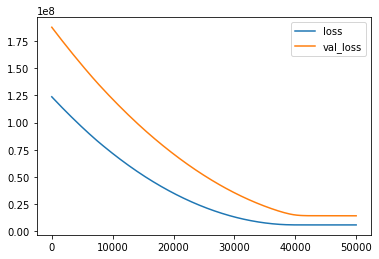

In [498]:
loss_df.plot()

In [499]:
model.evaluate(x_test, y_test, verbose=0)

14224635.90119863

In [500]:
model.evaluate(x_train, y_train, verbose=0)

5830672.280065744

In [501]:
predictions = model.predict(x_test)

In [502]:
predictions = pd.Series(predictions.reshape(len(predictions),))

In [503]:
predict_df = pd.DataFrame(y_test, columns=['Test True Y'])

In [504]:
predict_df = pd.concat([predict_df, predictions], axis=1)

In [505]:
predict_df.columns = ['Test True Y', 'Model Predictions']

<AxesSubplot:xlabel='Test True Y', ylabel='Model Predictions'>

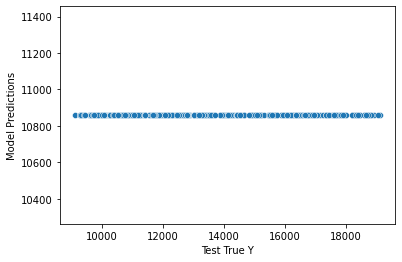

In [506]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=predict_df)

In [458]:
x_train[800]

array([0.19677791, 0.69565217, 0.09090909])

In [459]:
len(x_train)

8708